# Yelp - Recommender System
This project is implemented for "Algorithms for massive datasets" course.

**Full Name:** Reza Ghahremani

**Supervisor:** Prof. Dario Malchiodi

**Project Description:** https://docs.google.com/document/d/1Iu7eZ1oIGgvvcKk8m5fZ7CE00w9UmK06bL-6mdmUWWk/edit


**Yelp Dataset:**
The Yelp dataset is a subset of our businesses, reviews, and user data for use in connection with academic research. Available as JSON files, use it to teach students about databases, to learn NLP, or for sample production data while you learn how to make mobile apps.

**reference:** https://www.yelp.com/dataset

### Importing Datasets from Kaggle to Google Colab

In this section, you will see how we import the Yelp dataset from Kaggle to Google Colab (First of all, do "!pip install kaggle" command).

**reference:** https://github.com/Kaggle/kaggle-api

In [1]:
!pip install kaggle
!pip install tensorflow

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "rezaghahremani99"
os.environ['KAGGLE_KEY'] = "e4dc78335dd90b4e19c55752cdd91cef"

In [3]:
!kaggle datasets download -d yelp-dataset/yelp-dataset

100% 4.07G/4.07G [00:54<00:00, 126MB/s]
100% 4.07G/4.07G [00:55<00:00, 79.1MB/s]


In [4]:
!unzip '/content/yelp-dataset.zip'

Archive:  /content/yelp-dataset.zip
  inflating: Dataset_User_Agreement.pdf  
  inflating: yelp_academic_dataset_business.json  
  inflating: yelp_academic_dataset_checkin.json  
  inflating: yelp_academic_dataset_review.json  
  inflating: yelp_academic_dataset_tip.json  
  inflating: yelp_academic_dataset_user.json  


## Step 0: Data Preparation

**PySpark** is the Python API for Apache Spark, an open source, distributed computing framework and set of libraries for real-time, large-scale data processing.

**reference:** https://domino.ai/data-science-dictionary/pyspark

**Loading Requirements**

In [5]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark

!pip install PySpark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for PySpark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=988bf40c3ae3ce152b8f4f6ceca49f47d7a9e5415a7ee927d2977813b920a80a
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built PySpark


In [6]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.5.0-bin-hadoop3"

In [7]:
import findspark
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext

findspark.init("spark-3.5.0-bin-hadoop3")
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

type(spark)

pyspark.sql.session.SparkSession

**Loading Data**

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession

In [9]:
business_df = spark.read.json("yelp_academic_dataset_business.json")
review_df = spark.read.json("yelp_academic_dataset_review.json")
user_df = spark.read.json("yelp_academic_dataset_user.json")

In [10]:
business_df.show(5)
business_df.describe().show()

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|         city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|{NULL, NULL, NULL...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|Santa Barbara|                NULL|      0|34.4266787|-119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
|87 Grasso Plaza S...|{NULL, NULL, NULL...|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|       Affton|{8:0-18:30, 0:0-0...|      1| 38.551126|  -90.335695|    

In [ ]:
review_df.show(5)
review_df.describe().show()

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15|    0|Sx8TMOWLNuJBWer-0...|  4.0|Cute inter

In [ ]:
user_df.show(5)
user_df.describe().show()

+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+--------------------+----+--------------------+-----+------+------------+------+--------------------+-------------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer| cool|               elite|fans|             friends|funny|  name|review_count|useful|             user_id|      yelping_since|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+--------------------+----+--------------------+-----+------+------------+------+--------------------+-------------------+
|         3.91|    

As you can see, the business dataframe (business_df) includes 150346 businesses, the user dataframe (user_df) comprises 1987897 users, and the review dataframe (review_df) contains 6990280 reviews. The attributes of each dataframe are specified in the columns.

**Cleaning Data**

In [10]:
# Select the required columns from the dataset
business_cols = ['business_id', 'name', 'categories', 'city', 'latitude', 'longitude', 'is_open']
review_cols = ['review_id', 'user_id', 'business_id', 'stars', 'text']
user_cols = ['user_id', 'name']

business_df = business_df.select(business_cols)
review_df = review_df.select(review_cols)
user_df = user_df.select(user_cols)

business_df = business_df.na.drop()
review_df = review_df.na.drop()
user_df = user_df.na.drop()

In [ ]:
user_df.printSchema()
user_df.show(5)
user_df.describe().show()

root
 |-- user_id: string (nullable = true)
 |-- name: string (nullable = true)

+--------------------+------+
|             user_id|  name|
+--------------------+------+
|qVc8ODYU5SZjKXVBg...|Walker|
|j14WgRoU_-2ZE1aw1...|Daniel|
|2WnXYQFK0hXEoTxPt...| Steph|
|SZDeASXq7o05mMNLs...|  Gwen|
|hA5lMy-EnncsH4JoR...| Karen|
+--------------------+------+
only showing top 5 rows

+-------+--------------------+------------+
|summary|             user_id|        name|
+-------+--------------------+------------+
|  count|             1987897|     1987897|
|   mean|                NULL|         NaN|
| stddev|                NULL|         NaN|
|    min|---1lKK3aKOuomHnw...|       Chris|
|    max|zzzUFM4HFe0SFG0bP...|Ｊｏａｎｎｅ|
+-------+--------------------+------------+



In [ ]:
business_df.printSchema()
business_df.show(5)
business_df.describe().show()

root
 |-- business_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- city: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- is_open: long (nullable = true)

+--------------------+--------------------+--------------------+-------------+----------+------------+-------+
|         business_id|                name|          categories|         city|  latitude|   longitude|is_open|
+--------------------+--------------------+--------------------+-------------+----------+------------+-------+
|Pns2l4eNsfO8kk83d...|Abby Rappoport, L...|Doctors, Traditio...|Santa Barbara|34.4266787|-119.7111968|      0|
|mpf3x-BjTdTEA3yCZ...|       The UPS Store|Shipping Centers,...|       Affton| 38.551126|  -90.335695|      1|
|tUFrWirKiKi_TAnsV...|              Target|Department Stores...|       Tucson| 32.223236| -110.880452|      0|
|MTSW4McQd7CbVtyjq...|  St Honore Pastries|Restaurant

In [ ]:
review_df.printSchema()
review_df.show(5)
review_df.describe().show()

root
 |-- review_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)

+--------------------+--------------------+--------------------+-----+--------------------+
|           review_id|             user_id|         business_id|stars|                text|
+--------------------+--------------------+--------------------+-----+--------------------+
|KU_O5udG6zpxOg-Vc...|mh_-eMZ6K5RLWhZyI...|XQfwVwDr-v0ZS3_Cb...|  3.0|If you decide to ...|
|BiTunyQ73aT9WBnpR...|OyoGAe7OKpv6SyGZT...|7ATYjTIgM3jUlt4UM...|  5.0|I've taken a lot ...|
|saUsX_uimxRlCVr67...|8g_iMtfSiwikVnbP2...|YjUWPpI6HXG530lwP...|  3.0|Family diner. Had...|
|AqPFMleE6RsU23_au...|_7bHUi9Uuf5__HHc_...|kxX2SOes4o-D3ZQBk...|  5.0|Wow!  Yummy, diff...|
|Sx8TMOWLNuJBWer-0...|bcjbaE6dDog4jkNY9...|e4Vwtrqf-wpJfwesg...|  4.0|Cute interior and...|
+--------------------+--------------------+-------------------

**Add an ID column for each dataset**

In [11]:
business_newid_df = spark.createDataFrame(business_df.rdd.map(lambda x: x[0]).zipWithIndex(), \
        StructType([StructField("business_id", StringType(), True),StructField("businessId", IntegerType(), True)]))

a = business_df.alias("a")
b = business_newid_df.alias("b")

business_new_df = a.join(b, col("a.business_id") == col("b.business_id"), 'inner') \
             .select([col('a.'+xx) for xx in a.columns] + [col('b.businessId')])

business_new_df.select('businessId','business_id', 'name', 'categories', 'city', 'latitude', 'longitude', 'is_open').show()

+----------+--------------------+--------------------+--------------------+-------------+-------------+---------------+-------+
|businessId|         business_id|                name|          categories|         city|     latitude|      longitude|is_open|
+----------+--------------------+--------------------+--------------------+-------------+-------------+---------------+-------+
|        20|WKMJwqnfZKsAae75R...|Roast Coffeehouse...|Coffee & Tea, Foo...|     Edmonton|   53.5460453|   -113.4991693|      0|
|        97|knQ4vIgx-r85kjlWV...|Silver and Blue O...|Sporting Goods, S...|         Reno|    39.476518|   -119.7840369|      1|
|       291|1dSKEitDDgIkaApe6...|     The Pepper Pott|Caribbean, Food, ...|    Nashville|   36.1530043|    -86.8433279|      1|
|       553|adATTqggIQX5xxLDI...|        Just Churros|Food Trucks, Rest...|       Tucson|32.2712313189|-110.9920754497|      1|
|       556|vxrGNnuEef7YCfB7m...|             Dunkin'|Coffee & Tea, Don...|Pinellas Park|   27.8718285| 

In [12]:
user_newid_df = spark.createDataFrame(user_df.rdd.map(lambda x: x[0]).zipWithIndex(), \
        StructType([StructField("user_id", StringType(), True),StructField("userId", IntegerType(), True)]))

a = user_df.alias("a")
b = user_newid_df.alias("b")

user_new_df = a.join(b, col("a.user_id") == col("b.user_id"), 'inner') \
             .select([col('a.'+xx) for xx in a.columns] + [col('b.userId')])

user_new_df.select('userId','user_id', 'name').show()

+-------+--------------------+---------+
| userId|             user_id|     name|
+-------+--------------------+---------+
|  27105|---2PmXbF47D870st...|    Susan|
|  90950|---UgP94gokyCDuB5...|   Leonel|
|  78319|---r61b7EpVPkb4UV...|    Brian|
|1835336|--0DrQkM0FT-yCQRW...|    Jimmy|
|1359651|--0nrvOSAIuhL1Tk4...|      Ted|
|1552408|--13zE3NaRvLSrmfT...|Madeleine|
|1761222|--1oZcRo9-QKOtTqR...|   Claire|
| 445484|--1orhUoGFSdHXsox...|     Keny|
|1675711|--1vcleKg-_ORilNx...| Michelle|
| 924321|--1xed48O2w6o-TLq...|Elizabeth|
|1422611|--238OiSJBDIhfqcS...|   Ronald|
| 298314|--2F5G5LKt3h2cAXJ...|     Eric|
|1352938|--2eQbUFyRvXKgc-A...|     Tina|
| 941845|--3Hl2oAvTPlq-f7K...|    Rogan|
|1184588|--3PldvWEZ_bhLNsy...|  Michael|
|1169121|--3mk6jqZi0Km2kX8...|     Tres|
| 174173|--4AjktZiHowEIBCM...|     Bert|
|1657771|--4T2OChSFzSvcYG8...|   Sharon|
| 655164|--4_p6Z3tKadJcr9N...|    Amber|
|1373434|--4wsx_CrQyZxJYvH...|     Hugh|
+-------+--------------------+---------+
only showing top

In [13]:
new_review_df = review_df.select('user_id', 'business_id', 'stars', 'text')

a = new_review_df.alias("a")
b = user_newid_df.alias("b")

review_userId_df = a.join(b, col("a.user_id") == col("b.user_id"), 'inner') \
                     .select([col('a.'+xx) for xx in a.columns] + [col('b.userId')])

a = review_userId_df.alias("a")
b = business_newid_df.alias("b")

review_userId_businessId_df = a.join(b, col("a.business_id") == col("b.business_id"), 'inner') \
                         .select([col('a.'+xx) for xx in a.columns] + [col('b.businessId')])

review_userId_businessId_df.show()

+--------------------+--------------------+-----+--------------------+-------+----------+
|             user_id|         business_id|stars|                text| userId|businessId|
+--------------------+--------------------+-----+--------------------+-------+----------+
|-3-GR6zLPQUQXC02x...|L-VNs3YquPGKVsXl2...|  5.0|So freaking delic...|  92672|     80037|
|-3s52C4zL_DHRK0UL...|L-VNs3YquPGKVsXl2...|  4.0|Great oysters and...|   6441|     80037|
|-3s52C4zL_DHRK0UL...|2IahpaBR4U2Kdy9HF...|  3.0|sweet coffee? wei...|   6441|    128751|
|-3s52C4zL_DHRK0UL...|2IahpaBR4U2Kdy9HF...|  2.0|Another coffee sh...|   6441|    128751|
|-3s52C4zL_DHRK0UL...|WvlCQhLQGza1wj0Ho...|  1.0|Not sure what to ...|   6441|    123366|
|-55DgUo52I3zW9Rxk...|b54tS94cq0r0STDEU...|  5.0|Great hair cut. W...| 621219|     33975|
|-A62H3Q174V1rMWPz...|7hRaOnXRRS8q620F6...|  5.0|I usually visit t...| 471604|    127398|
|-EBZLf7mtJ5MrSvyo...|CBrD7r4PTCAKc7sP_...|  4.0|Absolutely wonder...| 946515|     97574|
|-HYCAMf2m

## Step 1: Exploratory Data Analysis

**Extraction of business categories**

In [ ]:
from pyspark.sql.functions import explode, split, col

business_exploded = business_new_df.withColumn("category", explode(split("categories", ",\s*")))
category_counts = business_exploded.groupBy("category").count().orderBy(col("count").desc())
category_counts = category_counts.withColumnRenamed("category", "Categories").withColumnRenamed("count", "Count")

category_counts.show()

+--------------------+-----+
|          Categories|Count|
+--------------------+-----+
|         Restaurants|52268|
|                Food|27781|
|            Shopping|24395|
|       Home Services|14356|
|       Beauty & Spas|14292|
|           Nightlife|12281|
|    Health & Medical|11890|
|      Local Services|11198|
|                Bars|11065|
|          Automotive|10773|
|Event Planning & ...| 9895|
|          Sandwiches| 8366|
|American (Traditi...| 8139|
|         Active Life| 7687|
|               Pizza| 7093|
|        Coffee & Tea| 6703|
|           Fast Food| 6472|
|  Breakfast & Brunch| 6239|
|      American (New)| 6097|
|     Hotels & Travel| 5857|
+--------------------+-----+
only showing top 20 rows



**Analyzing Rating Distribution, Reviews Per User, Reviews Per Business**




In [ ]:
rating_distribution = review_df.groupBy("stars").count().orderBy("stars")
rating_distribution.show()

+-----+-------+
|stars|  count|
+-----+-------+
|  1.0|1069561|
|  2.0| 544240|
|  3.0| 691934|
|  4.0|1452918|
|  5.0|3231627|
+-----+-------+



In [ ]:
# Reviews Per User
reviews_per_user = review_df.groupBy("user_id").count().orderBy(col("count").desc())
reviews_per_user.show()

+--------------------+-----+
|             user_id|count|
+--------------------+-----+
|_BcWyKQL16ndpBdgg...| 3048|
|Xw7ZjaGfr0WNVt6s_...| 1840|
|0Igx-a1wAstiBDerG...| 1747|
|-G7Zkl1wIWBBmD0KR...| 1682|
|ET8n-r7glWYqZhuR6...| 1653|
|bYENop4BuQepBjM1-...| 1578|
|1HM81n6n4iPIFU5d2...| 1554|
|fr1Hz2acAb3OaL3l6...| 1447|
|wXdbkFZsfDR7utJvb...| 1396|
|Um5bfs5DH6eizgjH3...| 1391|
|qjfMBIZpQT9DDtw_B...| 1324|
|VL12EhEdT4OWqGq0n...| 1308|
|bJ5FtCtZX3ZZacz2_...| 1298|
|pou3BbKsIozfH50rx...| 1247|
|ouODopBKF3AqfCkuQ...| 1129|
|B-s-8VUnuBjGTP3d0...| 1087|
|-kLVfaJytOJY2-QdQ...| 1076|
|vHc-UrI9yfL_pnnc6...| 1071|
|CfX4sTIFFNaRchNsw...| 1047|
|AHRrG3T1gJpHvtpZ-...| 1041|
+--------------------+-----+
only showing top 20 rows



In [ ]:
# Reviews Per Business
reviews_per_business = review_df.groupBy("business_id").count().orderBy(col("count").desc())
reviews_per_business.show()

+--------------------+-----+
|         business_id|count|
+--------------------+-----+
|_ab50qdWOk0DdB6XO...| 7673|
|ac1AeYqs8Z4_e2X5M...| 7516|
|GXFMD0Z4jEVZBCsbP...| 6160|
|ytynqOUb3hjKeJfRj...| 5778|
|oBNrLz4EDhiscSlbO...| 5264|
|iSRTaT9WngzB8JJ2Y...| 5254|
|VQcCL9PiNL_wkGf-u...| 5146|
|_C7QiQQc47AOEv4PE...| 4969|
|GBTPC53ZrG1ZBY3DT...| 4661|
|6a4gLLFSgr-Q6CZXD...| 4480|
|PP3BBaVxZLcJU54uP...| 4293|
|1b5mnK8bMnnju_cvU...| 4247|
|I_3LMZ_1m2mzR0oLI...| 4093|
|VaO-VW3e1kARkU9bP...| 4034|
|qb28j-FNX1_6xm7u3...| 3971|
|gTC8IQ_i8zXytWSly...| 3917|
|yPSejq3_erxo9zdVY...| 3889|
|wz8ZPfySQczcPgSyd...| 3634|
|VVH6k9-ycttH3TV_l...| 3633|
|IkY2ticzHEn4QFn8h...| 3428|
+--------------------+-----+
only showing top 20 rows



**Top 50 Most Reviewed Businesses**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

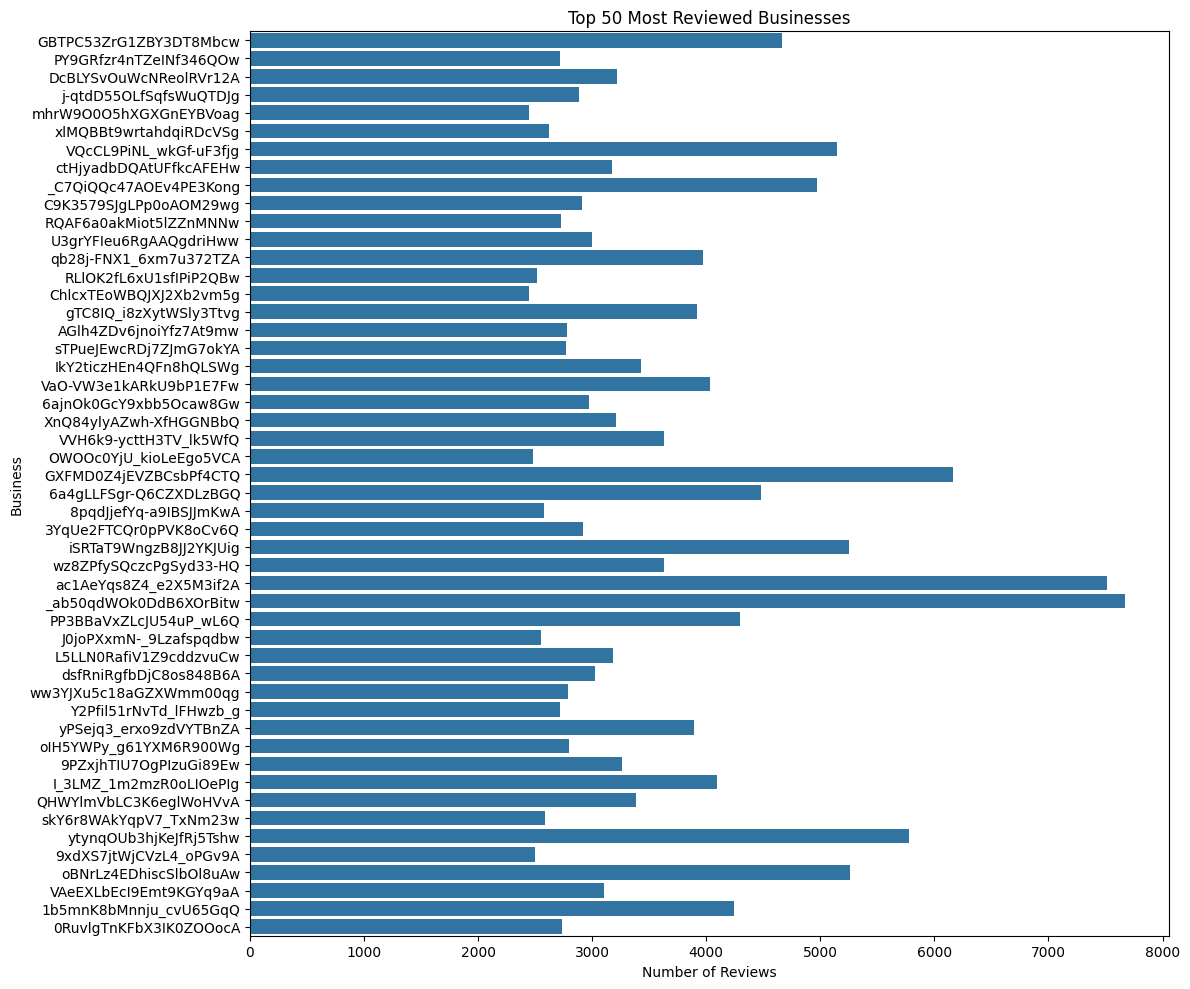

In [ ]:
from pyspark.sql.functions import col

most_reviewed_businesses = review_df.groupBy("business_id").count().orderBy(col("count").desc())

top_50_businesses = most_reviewed_businesses.limit(50)

top_50_businesses_with_names = top_50_businesses.join(business_df, "business_id").select("business_id", "count")

top_50_businesses_pd = top_50_businesses_with_names.toPandas()

plt.figure(figsize=(12, 10))
sns.barplot(x="count", y="business_id", data=top_50_businesses_pd)
plt.title("Top 50 Most Reviewed Businesses")
plt.xlabel("Number of Reviews")
plt.ylabel("Business")
plt.tight_layout()
plt.show()

**A Glimpse at Business Categories**

In [ ]:
businesses = business_new_df.withColumn("categories", split(business_new_df["categories"], ","))
businesses.show()

+--------------------+--------------------+--------------------+-------------+-------------+---------------+-------+----------+
|         business_id|                name|          categories|         city|     latitude|      longitude|is_open|businessId|
+--------------------+--------------------+--------------------+-------------+-------------+---------------+-------+----------+
|WKMJwqnfZKsAae75R...|Roast Coffeehouse...|[Coffee & Tea,  F...|     Edmonton|   53.5460453|   -113.4991693|      0|        20|
|knQ4vIgx-r85kjlWV...|Silver and Blue O...|[Sporting Goods, ...|         Reno|    39.476518|   -119.7840369|      1|        97|
|1dSKEitDDgIkaApe6...|     The Pepper Pott|[Caribbean,  Food...|    Nashville|   36.1530043|    -86.8433279|      1|       291|
|adATTqggIQX5xxLDI...|        Just Churros|[Food Trucks,  Re...|       Tucson|32.2712313189|-110.9920754497|      1|       553|
|vxrGNnuEef7YCfB7m...|             Dunkin'|[Coffee & Tea,  D...|Pinellas Park|   27.8718285|    -82.7502

**Display cities based on the number of businesses**

In [ ]:
from pyspark.sql.functions import col

city_business_counts = business_new_df.groupBy("city").count()
city_business_counts = city_business_counts.withColumnRenamed("count", "number_of_businesses")
top_20_cities = city_business_counts.orderBy(col("number_of_businesses").desc()).limit(20)

top_20_cities.show(20)

+----------------+--------------------+
|            city|number_of_businesses|
+----------------+--------------------+
|    Philadelphia|               14560|
|          Tucson|                9244|
|           Tampa|                9042|
|    Indianapolis|                7537|
|       Nashville|                6969|
|     New Orleans|                6208|
|            Reno|                5929|
|        Edmonton|                5053|
|     Saint Louis|                4824|
|   Santa Barbara|                3828|
|           Boise|                2934|
|      Clearwater|                2221|
|Saint Petersburg|                1660|
|        Metairie|                1639|
|          Sparks|                1621|
|      Wilmington|                1444|
|        Franklin|                1414|
|       St. Louis|                1255|
|  St. Petersburg|                1185|
|        Meridian|                1043|
+----------------+--------------------+



## Project 1: Finding similar items
**Project Description:** The task is to implement from scratch a detector of pairs of similar tweets, considering the text field of the dataset. You are free to preprocess the textual data using the techniques which you think are more appropriate, as well as to apply any of the methods explained during the lectures (or, of course, two or more methods).


**Data Preprocessing**

In [ ]:
review_df.show()
review_df.describe().show()

+--------------------+--------------------+--------------------+-----+--------------------+
|           review_id|             user_id|         business_id|stars|                text|
+--------------------+--------------------+--------------------+-----+--------------------+
|KU_O5udG6zpxOg-Vc...|mh_-eMZ6K5RLWhZyI...|XQfwVwDr-v0ZS3_Cb...|  3.0|If you decide to ...|
|BiTunyQ73aT9WBnpR...|OyoGAe7OKpv6SyGZT...|7ATYjTIgM3jUlt4UM...|  5.0|I've taken a lot ...|
|saUsX_uimxRlCVr67...|8g_iMtfSiwikVnbP2...|YjUWPpI6HXG530lwP...|  3.0|Family diner. Had...|
|AqPFMleE6RsU23_au...|_7bHUi9Uuf5__HHc_...|kxX2SOes4o-D3ZQBk...|  5.0|Wow!  Yummy, diff...|
|Sx8TMOWLNuJBWer-0...|bcjbaE6dDog4jkNY9...|e4Vwtrqf-wpJfwesg...|  4.0|Cute interior and...|
|JrIxlS1TzJ-iCu79u...|eUta8W_HdHMXPzLBB...|04UD14gamNjLY0IDY...|  1.0|I am a long term ...|
|6AxgBCNX_PNTOxmbR...|r3zeYsv1XFBRA4dJp...|gmjsEdUsKpj9Xxu6p...|  5.0|Loved this tour! ...|
|_ZeMknuYdlQcUqng_...|yfFzsLmaWF2d4Sr0U...|LHSTtnW3YHCeUkRDG...|  5.0|Amazingly 

In [76]:
tweets_df = review_df.select("review_id", "text")

In [77]:
sampled_tweets = tweets_df.sample(False, 0.00125)

In [78]:
sampled_tweets.show()
sampled_tweets.describe().show()

+--------------------+--------------------+
|           review_id|                text|
+--------------------+--------------------+
|suMtrxm_nUiAQMu6Z...|Say you decide th...|
|TW4DXj74C82qhGjOg...|Great place for a...|
|pIFGqL210EybhN6t0...|I really enjoy th...|
|MQFE_sU28cvL416QM...|The Lucky Perk is...|
|uAPQV0DhZ7Yd7n5Cu...|I would normally ...|
|XE7gjo1jS4yRx2okO...|This was my first...|
|YiIdFe_SGfDL0tA89...|We stopped by to ...|
|IWMk_Thy74Be4dEQW...|Ate breakfast her...|
|cO6Q_2mPr-11-hkZq...|Haven't had a cha...|
|6LgNzVt8kqSGpFqjW...|We had to go to C...|
|T5aNCHHuMp43YMV4Z...|Used to be called...|
|mZzfH9Rlan0EzIv23...|This review is ba...|
|nmdFMMIHKpOpoRHEX...|Slowest service I...|
|scbVrbp_ZAdai96Iw...|Terrible selectio...|
|eReyP3FREmhZJODiQ...|L9 and a pepsi! T...|
|0YzX-sOvTYyyZ2X68...|This place is goo...|
|FpLs_Hb5F4SMRnIVA...|Jayna is a great ...|
|dN1p3P8MGZIAPsc5e...|So disappointing....|
|bQqJCIbCOcBWVhH6A...|Best Mexican we h...|
|Wsej8I_aF42Ir1gnS...|Was hesita

In [203]:
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, Word2Vec, VectorAssembler, Normalizer, HashingTF, Word2VecModel

rt = RegexTokenizer(gaps = False, pattern = '\w+', inputCol = 'text', outputCol = 'token')
swr = StopWordsRemover(inputCol = 'token', outputCol = 'without_stopword')
cv = CountVectorizer(inputCol="without_stopword", outputCol="rawFeature")
idf = IDF(inputCol="rawFeature", outputCol="idf_vector")
w2v = Word2Vec(vectorSize = 100, minCount = 5, inputCol = 'without_stopword', outputCol = 'word_vector', seed = 123)
va = VectorAssembler(inputCols=['idf_vector', 'word_vector'], outputCol='comb_vector')
#norm = Normalizer(inputCol="comb_vector", outputCol="norm_vector")

pipeline = Pipeline(stages=[rt, swr, cv, idf, w2v, va])

In [204]:
model = pipeline.fit(sampled_tweets)
tweet_vectors = model.transform(sampled_tweets)

In [17]:
tweet_vectors.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|           review_id|                text|               token|    without_stopword|          rawFeature|          idf_vector|         word_vector|         comb_vector|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|NgMX1BwJd5meAWEqX...|Obviously they ar...|[obviously, they,...|[obviously, somet...|(23738,[1,59,63,8...|(23738,[1,59,63,8...|[0.04694007774814...|(23838,[1,59,63,8...|
|NmzPkd_qq7mC6uA_A...|Reviewing the foo...|[reviewing, the, ...|[reviewing, food,...|(23738,[0,1,3,6,1...|(23738,[0,1,3,6,1...|[0.08401187995008...|(23838,[0,1,3,6,1...|
|dSrA4BSbUaF5gjt2U...|My brother and I ...|[my, brother, and...|[brother, ate, ce...|(23738,[0,1,30,78...|(23738,[0,1,30,78...|[0.02605541506782...|(2

In [205]:
from pyspark.ml.feature import Normalizer

normalizer = Normalizer(inputCol="word_vector", outputCol="norm_word_vector")
norm_df = normalizer.transform(tweet_vectors)

**Finding Similar texts based on Cosine Similarity**

**Cosine similarity** measures the similarity between two vectors of an inner product space. It is measured by the cosine of the angle between two vectors and determines whether two vectors are pointing in roughly the same direction.

cosine similarity = $S_c(A, B) := \cos(\theta) = \frac{A \cdot B}{\|A\|\|B\|} = \frac{\sum_{i=1}^{n} A_i B_i}{\sqrt{\sum_{i=1}^{n} A_i^2} \sqrt{\sum_{i=1}^{n} B_i^2}}$

where $A_i$ and $B_i$ are the i-th components of vectors A and B, respectively.


**refernece:** https://en.wikipedia.org/wiki/Cosine_similarity

In [206]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

def cosine_similarity(vec1, vec2):
    dot_product = float(vec1.dot(vec2))
    norm_product = float(vec1.norm(2) * vec2.norm(2))
    similarity = dot_product / norm_product if norm_product != 0 else 0.0
    return similarity

cosine_similarity_udf = udf(cosine_similarity)

In [207]:
similarities = norm_df.alias("a").crossJoin(norm_df.alias("b")) \
    .selectExpr("a.review_id as review_id1", "b.review_id as review_id2",
                "a.text as text1", "b.text as text2",
                "a.norm_word_vector as vec1", "b.norm_word_vector as vec2") \
    .withColumn("similarity", cosine_similarity_udf("vec1", "vec2"))

In [208]:
threshold = 0.85
similar_tweets = similarities.filter(similarities.similarity > threshold)

In [209]:
similar_tweets.show(truncate = False)

+----------------------+----------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [22]:
similar_tweets.show()

+--------------------+--------------------+--------------------+--------------------+------------------+
|          review_id1|          review_id2|                vec1|                vec2|        similarity|
+--------------------+--------------------+--------------------+--------------------+------------------+
|NgMX1BwJd5meAWEqX...|NgMX1BwJd5meAWEqX...|[0.15526445500289...|[0.15526445500289...|               1.0|
|NgMX1BwJd5meAWEqX...|qgkAfUcGfOCVxASyy...|[0.15526445500289...|[0.15679934958286...|0.9051112403308534|
|NgMX1BwJd5meAWEqX...|gl1UEBPwH7iyOncoa...|[0.15526445500289...|[0.06522373378134...|0.8514364779311778|
|NgMX1BwJd5meAWEqX...|gkrbVAV15KAxP4QKB...|[0.15526445500289...|[0.15623204721792...| 0.858295556914858|
|NgMX1BwJd5meAWEqX...|0t761sbWxkz5j3TgF...|[0.15526445500289...|[0.17814075444714...|0.8747772985541101|
|NgMX1BwJd5meAWEqX...|_267tGkIjlNXujrl5...|[0.15526445500289...|[0.14532320068230...|0.8885948046047326|
|NgMX1BwJd5meAWEqX...|1Zt3KbGM4gIlOnsSn...|[0.155264455

In [25]:
"""def find_similar_reviews(review_id):
    similar_reviews = similar_tweets.filter((similar_tweets.review_id1 == review_id) | (similar_tweets.review_id2 == review_id))
    similar_reviews_data = similar_reviews.selectExpr(
        "case when review_id1 = '{}' then review_id2 else review_id1 end as similar_review_id".format(review_id),
        "similarity"
    ).collect()
    for row in similar_reviews_data:
        print("Similar Review ID: {}, Similarity: {}".format(row.similar_review_id, row.similarity))

input_review_id = "XQLxqZPXkSJX4udMpCeLIw"
find_similar_reviews(input_review_id)"""

'def find_similar_reviews(review_id):\n    similar_reviews = similar_tweets.filter((similar_tweets.review_id1 == review_id) | (similar_tweets.review_id2 == review_id))\n    similar_reviews_data = similar_reviews.selectExpr(\n        "case when review_id1 = \'{}\' then review_id2 else review_id1 end as similar_review_id".format(review_id),\n        "similarity"\n    ).collect()\n    for row in similar_reviews_data:\n        print("Similar Review ID: {}, Similarity: {}".format(row.similar_review_id, row.similarity))\n\ninput_review_id = "XQLxqZPXkSJX4udMpCeLIw"\nfind_similar_reviews(input_review_id)'

**Finding Similar Texts based on LSH and EuclideanDistance**

In [210]:
from pyspark.ml.feature import BucketedRandomProjectionLSH

brp = BucketedRandomProjectionLSH(inputCol="norm_word_vector", outputCol="hashes", bucketLength=0.1, numHashTables=3)
model = brp.fit(norm_df)
df_hashed = model.transform(norm_df)

In [211]:
similarity_threshold = 0.85
similar_items = model.approxSimilarityJoin(df_hashed, df_hashed, threshold=similarity_threshold, distCol="EuclideanDistance")

In [212]:
similar_items_filtered = similar_items.filter("datasetA.text != datasetB.text") \
                                      .select(col("datasetA.text").alias("idA"),
                                              col("datasetB.text").alias("idB"),
                                              col("EuclideanDistance"))

In [ ]:
similar_items_filtered.limit(100).show()

## Project 6: Clustering
**Project Description:** The task is to implement from scratch a clustering system for reviews. You are free to choose the representation of reviews and the clustering algorithm, provided that the latter scales up with data size.

**Note:** The Data Preprocessing step is implemented in Project 1.

In [ ]:
tweets_df = review_df.select("review_id", "text")

In [ ]:
sampled_tweets = tweets_df.sample(False, 0.00125)

In [79]:
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, Word2Vec, VectorAssembler, Normalizer, HashingTF, Word2VecModel

rt = RegexTokenizer(gaps = False, pattern = '\w+', inputCol = 'text', outputCol = 'token')
swr = StopWordsRemover(inputCol = 'token', outputCol = 'without_stopword')
cv = CountVectorizer(inputCol="without_stopword", outputCol="rawFeature")
idf = IDF(inputCol="rawFeature", outputCol="idf_vector")
w2v = Word2Vec(vectorSize = 100, minCount = 5, inputCol = 'without_stopword', outputCol = 'word_vector', seed = 123)
#va = VectorAssembler(inputCols=['idf_vector', 'word_vector'], outputCol='comb_vector')
#norm = Normalizer(inputCol="comb_vector", outputCol="norm_vector")

pipeline = Pipeline(stages=[rt, swr, cv, idf, w2v, va])

In [80]:
model = pipeline.fit(sampled_tweets)
tweet_vectors = model.transform(sampled_tweets)

In [69]:
tweet_vectors.describe().show()

+-------+--------------------+--------------------+
|summary|           review_id|                text|
+-------+--------------------+--------------------+
|  count|                8755|                8755|
|   mean|                NULL|                NULL|
| stddev|                NULL|                NULL|
|    min|--C34ryBxYIm0T-tV...|"Every time I hav...|
|    max|zzf_qapyoiCXMtJx6...|your restaurant e...|
+-------+--------------------+--------------------+



In [81]:
features_df = tweet_vectors.select("word_vector")

In [82]:
features_rdd = features_df.rdd.map(lambda x: x[0])

In [132]:
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [133]:
def initialize_centroids(data, k):
    """Randomly initialize centroids."""
    n_samples, _ = data.shape
    indices = np.random.choice(n_samples, size=k, replace=False)
    centroids = data[indices]
    return centroids

In [130]:
def assign_clusters(data, centroids):
    """Assign each data point to the nearest centroid."""
    distances = np.sqrt(((data - centroids[:, np.newaxis])**2).sum(axis=2))
    return np.argmin(distances, axis=0)

In [128]:
def update_centroids(data, clusters, k):
    """Update centroids based on the mean of data points assigned to each cluster."""
    new_centroids = np.zeros((k, data.shape[1]))
    for i in range(k):
        points = data[clusters == i]
        if len(points) > 0:
            new_centroids[i] = points.mean(axis=0)
        else:
            new_centroids[i] = np.random.rand(data.shape[1])  # Reinitialize empty cluster centroid
    return new_centroids

In [127]:
def kmeans(data, k, max_iters=100):
    """Run K-means algorithm."""
    centroids = initialize_centroids(data, k)
    for _ in range(max_iters):
        clusters = assign_clusters(data, centroids)
        new_centroids = update_centroids(data, clusters, k)
        # Check for convergence
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    return clusters, centroids

In [134]:
def silhouette(data, clusters):
    """Compute silhouette score."""
    return silhouette_score(data, clusters)

In [135]:
def visualize_clusters(data, clusters, centroids, pca=True):
    """Visualize clusters using PCA for dimensionality reduction."""
    if pca:
        pca = PCA(n_components=2)
        data_pca = pca.fit_transform(data)
        centroids_pca = pca.transform(centroids)
    else:
        data_pca = data
        centroids_pca = centroids

    plt.figure(figsize=(8, 6))
    plt.scatter(data_pca[:, 0], data_pca[:, 1], c=clusters, cmap='viridis', alpha=0.5)
    plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='x', c='red', s=100, label='Centroids')
    plt.title('K-means Clustering')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

In [87]:
norm_word_vectors = tweet_vectors.select('word_vector').rdd.map(lambda row: row[0]).collect()

In [88]:
norm_word_vectors_np = np.array(norm_word_vectors)

Number of tweets in each cluster:
0    3598
1    2851
2    2303
dtype: int64
silhouette_score:  0.23273440116079355


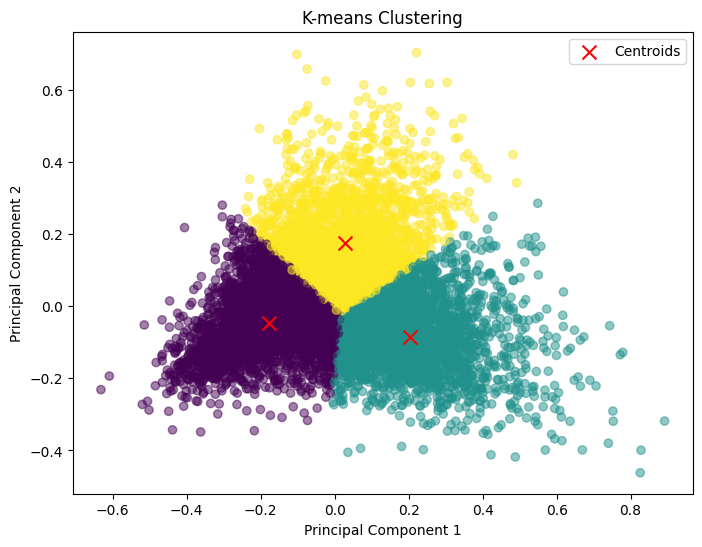

In [161]:
clusters, centroids = kmeans(norm_word_vectors_np, k=3)

import pandas as pd
clusters_series = pd.Series(clusters)
cluster_counts = clusters_series.value_counts()
print("Number of tweets in each cluster:")
print(cluster_counts)

from sklearn.metrics import silhouette_score
silhouette_score = silhouette(norm_word_vectors_np, clusters)
print("silhouette_score: ", silhouette_score)

visualize_clusters(norm_word_vectors_np, clusters, centroids, pca=True)

In [188]:
def analyze_cluster_centroids(centroids, feature_names, n_top_words=10):
    for i, centroid in enumerate(centroids):
        print(f"Cluster {i}:")
        top_word_indices = centroid.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[idx] for idx in top_word_indices]
        print(f"Top Words: {', '.join(top_words)}")

In [202]:
feature_names = model.stages[2].vocabulary

In [191]:
analyze_cluster_centroids(centroids, feature_names, n_top_words=20)

Cluster 0:
Top Words: another, didn, recommend, times, sauce, 3, something, give, 2, service, well, also, ever, minutes, one, going, people, love, much, everything
Cluster 1:
Top Words: never, 5, two, wait, told, ordered, table, way, said, staff, every, give, went, pizza, experience, always, amazing, get, something, cheese
Cluster 2:
Top Words: also, told, wait, every, well, two, give, table, another, times, always, recommend, service, didn, eat, way, never, experience, try, 5


Number of tweets in each cluster:
2    2763
0    2689
3    1815
1    1485
dtype: int64
silhouette_score:  0.15855075311439218


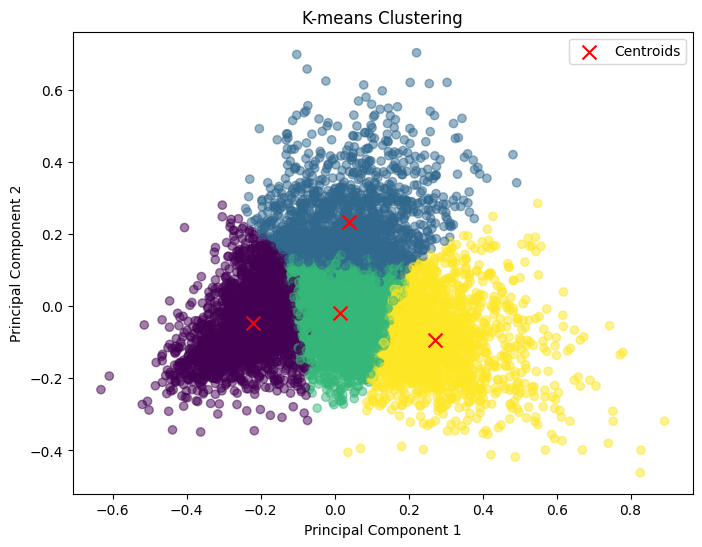

In [157]:
clusters, centroids = kmeans(norm_word_vectors_np, k=4)

import pandas as pd
clusters_series = pd.Series(clusters)
cluster_counts = clusters_series.value_counts()
print("Number of tweets in each cluster:")
print(cluster_counts)

from sklearn.metrics import silhouette_score
silhouette_score = silhouette(norm_word_vectors_np, clusters)
print("silhouette_score: ", silhouette_score)

visualize_clusters(norm_word_vectors_np, clusters, centroids, pca=True)

Number of tweets in each cluster:
0    2325
4    2283
2    1581
3    1299
1    1264
dtype: int64
silhouette_score:  0.13990155116857203


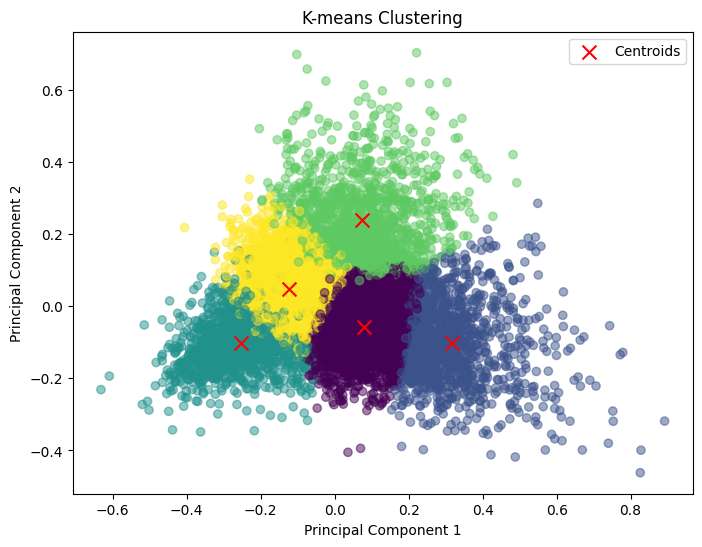

In [155]:
clusters, centroids = kmeans(norm_word_vectors_np, k=5)

import pandas as pd
clusters_series = pd.Series(clusters)
cluster_counts = clusters_series.value_counts()
print("Number of tweets in each cluster:")
print(cluster_counts)

from sklearn.metrics import silhouette_score
silhouette_score = silhouette(norm_word_vectors_np, clusters)
print("silhouette_score: ", silhouette_score)

visualize_clusters(norm_word_vectors_np, clusters, centroids, pca=True)

Number of tweets in each cluster:
0    1542
3    1423
2    1314
9     808
7     739
1     735
4     658
5     628
8     571
6     334
dtype: int64
silhouette_score:  0.11629176163827545


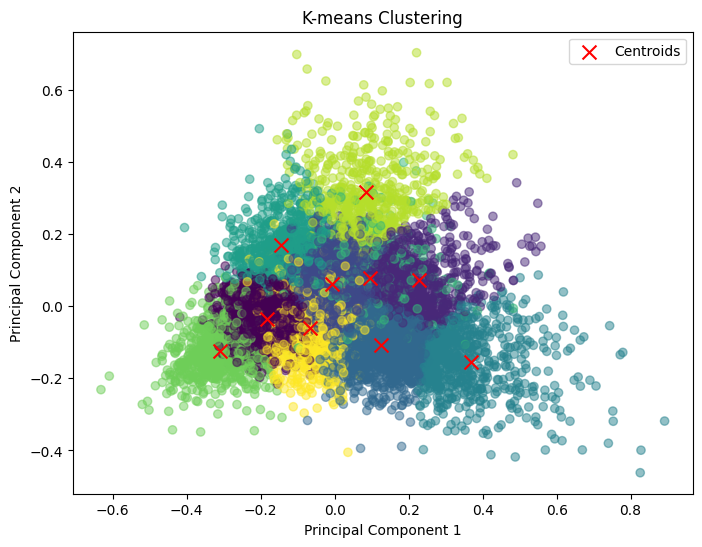

In [153]:
clusters, centroids = kmeans(norm_word_vectors_np, k=10)

import pandas as pd
clusters_series = pd.Series(clusters)
cluster_counts = clusters_series.value_counts()
print("Number of tweets in each cluster:")
print(cluster_counts)

from sklearn.metrics import silhouette_score
silhouette_score = silhouette(norm_word_vectors_np, clusters)
print("silhouette_score: ", silhouette_score)

visualize_clusters(norm_word_vectors_np, clusters, centroids, pca=True)

Number of tweets in each cluster:
14    426
27    390
39    361
42    348
37    323
35    293
33    276
28    273
1     263
43    256
22    239
44    237
38    235
40    230
36    228
18    212
8     200
17    194
9     193
24    189
0     186
6     171
15    169
23    168
34    168
25    166
30    166
11    154
7     148
48    136
45    127
10    126
2     121
32    116
5     112
29    111
12    107
21    105
46    100
47     93
4      92
16     87
3      86
19     75
31     74
13     67
49     60
20     48
26     46
41      1
dtype: int64
silhouette_score:  0.051903759802834556


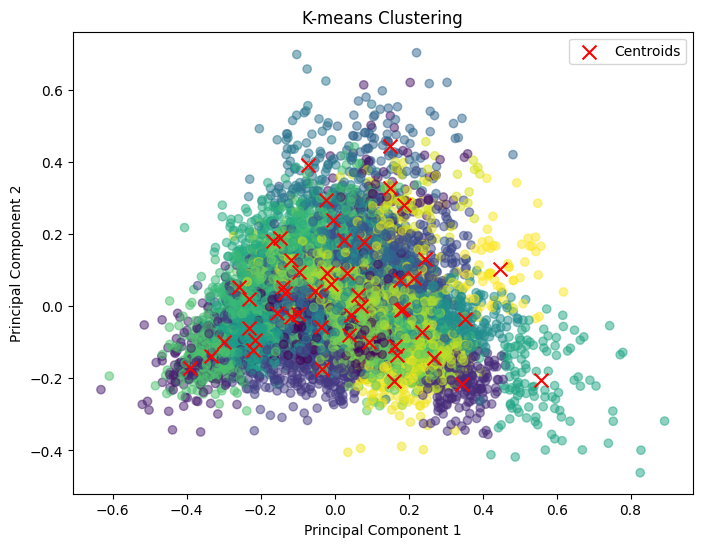

In [154]:
clusters, centroids = kmeans(norm_word_vectors_np, k=50)

import pandas as pd
clusters_series = pd.Series(clusters)
cluster_counts = clusters_series.value_counts()
print("Number of tweets in each cluster:")
print(cluster_counts)

from sklearn.metrics import silhouette_score
silhouette_score = silhouette(norm_word_vectors_np, clusters)
print("silhouette_score: ", silhouette_score)

visualize_clusters(norm_word_vectors_np, clusters, centroids, pca=True)

Number of tweets in each cluster:
6     215
53    209
2     190
22    184
21    183
     ... 
76     30
66     28
78     27
0      25
54     23
Length: 100, dtype: int64
silhouette_score:  0.041956813087861304


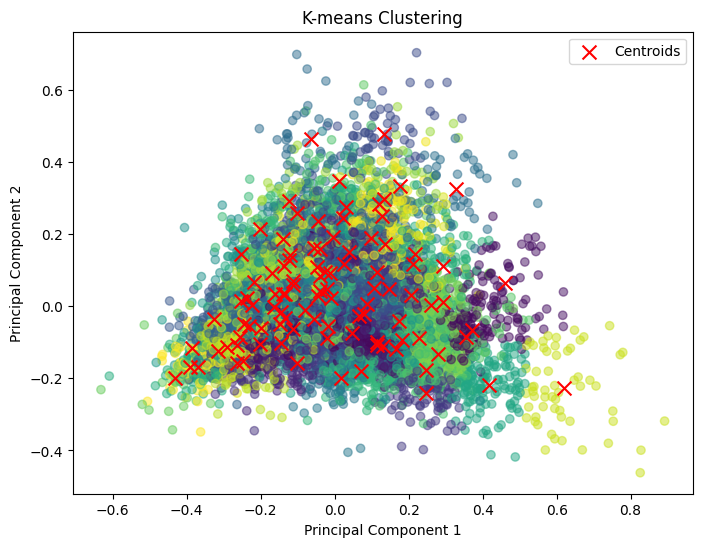

In [156]:
clusters, centroids = kmeans(norm_word_vectors_np, k=100)

import pandas as pd
clusters_series = pd.Series(clusters)
cluster_counts = clusters_series.value_counts()
print("Number of tweets in each cluster:")
print(cluster_counts)

from sklearn.metrics import silhouette_score
silhouette_score = silhouette(norm_word_vectors_np, clusters)
print("silhouette_score: ", silhouette_score)

visualize_clusters(norm_word_vectors_np, clusters, centroids, pca=True)

## Project 4: Recommender systems
**Project Description:** The task is to implement from scratch a system recommending businesses to users. You are free to choose the technique at the basis of the recommender system, as well as the strategy to be used in order to populate the utility matrix.


In [14]:
from pyspark.sql.functions import udf, col, lit
from pyspark.sql.types import StructType, StructField, StringType, FloatType
import numpy as np

**Filtering Data**

Due to the large amount of data and to avoid time consuming, we select a subset of the dataset through filtering by choosing "Edmonton" city.

In [15]:
target_cities = ["Edmonton"]

selected_businesses = business_new_df.filter(business_new_df.city.isin(target_cities) & (business_new_df.is_open == 1))
selected_businesses.show()

+--------------------+--------------------+--------------------+--------+-------------+---------------+-------+----------+
|         business_id|                name|          categories|    city|     latitude|      longitude|is_open|businessId|
+--------------------+--------------------+--------------------+--------+-------------+---------------+-------+----------+
|oo2xOkcHIelQrEczc...|Crystal Glass Sou...|Auto Glass Servic...|Edmonton|    53.449484|    -113.480919|      1|     10462|
|R_3EhO4r3kMSw_W9D...|           Starbucks|  Food, Coffee & Tea|Edmonton|   53.4555859|   -113.5154895|      1|     15535|
|O-ZzRg_RHX1i0hIRV...|    Chateau Lighting|Shopping, Lightin...|Edmonton|   53.4812461|   -113.4853025|      1|     44473|
|pyXKQZ_XmuNLVfgSs...|       Em's Car Wash|Car Wash, Automotive|Edmonton|   53.5054865|   -113.4868477|      1|     44793|
|e4WGdmp_10Cvpv0ZH...|   It's A Dog's Life|Pet Groomers, Pet...|Edmonton|    53.513128|    -113.437394|      1|     60606|
|05qVGl0KbrzU9gb

In [16]:
df_reviews = review_userId_businessId_df.join(selected_businesses, review_df.business_id == selected_businesses.business_id)
df_reviews = df_reviews.drop(selected_businesses.business_id).drop(selected_businesses.businessId)

In [17]:
df_reviews.show()
df_reviews.describe().show()

+--------------------+--------------------+-----+--------------------+-------+-------+--------------------+--------+-------------+---------------+-------+----------+
|             user_id|         business_id|stars|                text| userId|   name|          categories|    city|     latitude|      longitude|is_open|businessId|
+--------------------+--------------------+-----+--------------------+-------+-------+--------------------+--------+-------------+---------------+-------+----------+
|HDM7iz-x3TWnVKFFa...|-eAmwxqpedMfAHREj...|  5.0|Went to this plac...|1478078|An Chay|Vegetarian, Vietn...|Edmonton|53.5406978057|-113.5143306152|      1|    104328|
|rBK4_w8mXg7WRtxEr...|-eAmwxqpedMfAHREj...|  4.0|An chay just open...|  99592|An Chay|Vegetarian, Vietn...|Edmonton|53.5406978057|-113.5143306152|      1|    104328|
|I1MHrxdr98VXT-Dj-...|-eAmwxqpedMfAHREj...|  5.0|Another great veg...| 125364|An Chay|Vegetarian, Vietn...|Edmonton|53.5406978057|-113.5143306152|      1|    104328|
|UQQ

**Text Preprocessing and Analysis**

In this step, text processing is performed on the review texts, including tokenization, stop words removal, and vectorization using techniques like CountVectorizer and Word2Vec.

In [18]:
reviews_text = df_reviews.select("business_id", "businessId", "text", "stars")
reviews_text.show()

+--------------------+----------+--------------------+-----+
|         business_id|businessId|                text|stars|
+--------------------+----------+--------------------+-----+
|Wr2si_UEmex33UofP...|    125696|Clementine is a v...|  5.0|
|7Ug8vbtGILz5siCLf...|     81034|I really wanted t...|  3.0|
|bzQvlz7oUKFez_XMY...|    122389|I picked my kid u...|  4.0|
|bzQvlz7oUKFez_XMY...|    122389|Probably the long...|  1.0|
|3wLmMcYDXWkiAjLCF...|     71114|I ordered deliver...|  1.0|
|9-uRQkRkXdPQmnU1o...|     12604|I d heard this pl...|  2.0|
|LOzj0BsudeOeqoN5d...|     19610|Always busy as I ...|  4.0|
|LOzj0BsudeOeqoN5d...|     19610|Happy that they a...|  3.0|
|2qHVqbps43bf64Ej4...|     16874|Okay so the chick...|  2.0|
|2qHVqbps43bf64Ej4...|     16874|Delicious chicken...|  4.0|
|l1L4OLwoZIZ23AhXq...|     54326|I just moved to E...|  5.0|
|9-uRQkRkXdPQmnU1o...|     12604|Good ingredients....|  2.0|
|kPG6r0h73sPgXBei0...|      9325|When I first arri...|  4.0|
|kPG6r0h73sPgXBei0...|  

In [19]:
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, Word2Vec, VectorAssembler, Normalizer, HashingTF, Word2VecModel

rt = RegexTokenizer(gaps = False, pattern = '\w+', inputCol = 'text', outputCol = 'token')
swr = StopWordsRemover(inputCol = 'token', outputCol = 'without_stopword')
cv = CountVectorizer(inputCol="without_stopword", outputCol="rawFeature")
idf = IDF(inputCol="rawFeature", outputCol="idf_vector")
w2v = Word2Vec(vectorSize = 100, minCount = 5, inputCol = 'without_stopword', outputCol = 'word_vector', seed = 123)
va = VectorAssembler(inputCols=['idf_vector', 'word_vector'], outputCol='comb_vector')
#norm = Normalizer(inputCol="comb_vector", outputCol="norm_vector")

pipeline = Pipeline(stages=[rt, swr, cv, idf, w2v, va])

In [20]:
pp_model = pipeline.fit(reviews_text)
df = pp_model.transform(reviews_text)
df.show()

+--------------------+----------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|         business_id|businessId|                text|stars|               token|    without_stopword|          rawFeature|          idf_vector|         word_vector|         comb_vector|
+--------------------+----------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Wr2si_UEmex33UofP...|    125696|Clementine is a v...|  5.0|[clementine, is, ...|[clementine, spec...|(64164,[1,2,5,6,1...|(64164,[1,2,5,6,1...|[0.01878684718269...|(64264,[1,2,5,6,1...|
|7Ug8vbtGILz5siCLf...|     81034|I really wanted t...|  3.0|[i, really, wante...|[really, wanted, ...|(64164,[5,10,18,2...|(64164,[5,10,18,2...|[-0.0166305881724...|(64264,[5,10,18,2...|
|bzQvlz7oUKFez_XMY...|    122389|I picked my kid u...|  4.0|[i, p

**RegexTokenizer:**
A regex based tokenizer that extracts tokens either by using the provided regex pattern to split the text or repeatedly matching the regex.

**reference:** https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.ml.feature.RegexTokenizer.html

In [ ]:
"""regexTokenizer = RegexTokenizer(gaps = False, pattern = '\w+', inputCol = 'text', outputCol = 'token')
reviews_by_business_token_df = regexTokenizer.transform(reviews_text)
reviews_by_business_token_df.show()"""

+--------------------+----------+--------------------+-----+--------------------+
|         business_id|businessId|                text|stars|               token|
+--------------------+----------+--------------------+-----+--------------------+
|VwZ5NDbIu3elGQI6M...|     19055|Randomly came in ...|  4.0|[randomly, came, ...|
|2fJ-WxJlUN6azp3bz...|    105447|Beef Noodle Soup....|  4.0|[beef, noodle, so...|
|2fJ-WxJlUN6azp3bz...|    105447|Okay pho,  the br...|  3.0|[okay, pho, the, ...|
|r3X75SK37buS94mDl...|     98376|I wish we could g...|  5.0|[i, wish, we, cou...|
|2fJ-WxJlUN6azp3bz...|    105447|my husband and i ...|  4.0|[my, husband, and...|
|2fJ-WxJlUN6azp3bz...|    105447|This is probably ...|  5.0|[this, is, probab...|
|HRh-JeWCnn2sjG_He...|     30441|I absolutely love...|  5.0|[i, absolutely, l...|
|2fJ-WxJlUN6azp3bz...|    105447|The restaurant is...|  5.0|[the, restaurant,...|
|4AuBXliaKg3bDKVaa...|    131014|Went there for lu...|  1.0|[went, there, for...|
|wopwoiKIllIzcgg

**StopWordsRemover:** A feature transformer that filters out stop words from input. It can filter out multiple columns at once by setting the inputCols parameter.

**reference:** https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.ml.feature.StopWordsRemover.html#stopwordsremover

In [ ]:
"""stopWordsRemover = StopWordsRemover(inputCol = 'token', outputCol = 'without_stopword')
reviews_by_business_token_without_stopword_df = stopWordsRemover.transform(reviews_by_business_token_df)
reviews_by_business_token_without_stopword_df.show()"""

+--------------------+----------+--------------------+-----+--------------------+--------------------+
|         business_id|businessId|                text|stars|               token|    without_stopword|
+--------------------+----------+--------------------+-----+--------------------+--------------------+
|VwZ5NDbIu3elGQI6M...|     19055|Randomly came in ...|  4.0|[randomly, came, ...|[randomly, came, ...|
|2fJ-WxJlUN6azp3bz...|    105447|Beef Noodle Soup....|  4.0|[beef, noodle, so...|[beef, noodle, so...|
|2fJ-WxJlUN6azp3bz...|    105447|Okay pho,  the br...|  3.0|[okay, pho, the, ...|[okay, pho, broth...|
|r3X75SK37buS94mDl...|     98376|I wish we could g...|  5.0|[i, wish, we, cou...|[wish, get, one, ...|
|2fJ-WxJlUN6azp3bz...|    105447|my husband and i ...|  4.0|[my, husband, and...|[husband, several...|
|2fJ-WxJlUN6azp3bz...|    105447|This is probably ...|  5.0|[this, is, probab...|[probably, best, ...|
|HRh-JeWCnn2sjG_He...|     30441|I absolutely love...|  5.0|[i, absolutel

**CountVectorizer:** Extracts a vocabulary from document collections and generates a CountVectorizerModel.

**reference:** https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.CountVectorizer.html

In [ ]:
"""countVectorizer = CountVectorizer(inputCol="without_stopword", outputCol="rawFeature")
count_vectorizer_model = countVectorizer.fit(reviews_by_business_token_without_stopword_df)
reviews_by_business_featurized_df = count_vectorizer_model.transform(reviews_by_business_token_without_stopword_df)
reviews_by_business_featurized_df.show()"""

+--------------------+----------+--------------------+-----+--------------------+--------------------+--------------------+
|         business_id|businessId|                text|stars|               token|    without_stopword|          rawFeature|
+--------------------+----------+--------------------+-----+--------------------+--------------------+--------------------+
|VwZ5NDbIu3elGQI6M...|     19055|Randomly came in ...|  4.0|[randomly, came, ...|[randomly, came, ...|(178945,[1,2,5,6,...|
|2fJ-WxJlUN6azp3bz...|    105447|Beef Noodle Soup....|  4.0|[beef, noodle, so...|[beef, noodle, so...|(178945,[0,1,4,7,...|
|2fJ-WxJlUN6azp3bz...|    105447|Okay pho,  the br...|  3.0|[okay, pho, the, ...|[okay, pho, broth...|(178945,[21,50,20...|
|r3X75SK37buS94mDl...|     98376|I wish we could g...|  5.0|[i, wish, we, cou...|[wish, get, one, ...|(178945,[0,6,7,21...|
|2fJ-WxJlUN6azp3bz...|    105447|my husband and i ...|  4.0|[my, husband, and...|[husband, several...|(178945,[0,1,2,4,...|
|2fJ-WxJ

**IDF:** Compute the Inverse Document Frequency (IDF) given a collection of documents.

**reference:** https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.IDF.html

In [ ]:
"""idf = IDF(inputCol="rawFeature", outputCol="idf_vector")
idf_model = idf.fit(reviews_by_business_featurized_df)
reviews_by_business_rescaled_df = idf_model.transform(reviews_by_business_featurized_df)
reviews_by_business_rescaled_df.show()"""

+--------------------+----------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|         business_id|businessId|                text|stars|               token|    without_stopword|          rawFeature|          idf_vector|
+--------------------+----------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|VwZ5NDbIu3elGQI6M...|     19055|Randomly came in ...|  4.0|[randomly, came, ...|[randomly, came, ...|(178945,[1,2,5,6,...|(178945,[1,2,5,6,...|
|2fJ-WxJlUN6azp3bz...|    105447|Beef Noodle Soup....|  4.0|[beef, noodle, so...|[beef, noodle, so...|(178945,[0,1,4,7,...|(178945,[0,1,4,7,...|
|2fJ-WxJlUN6azp3bz...|    105447|Okay pho,  the br...|  3.0|[okay, pho, the, ...|[okay, pho, broth...|(178945,[21,50,20...|(178945,[21,50,20...|
|r3X75SK37buS94mDl...|     98376|I wish we could g...|  5.0|[i, wish, we, cou...|[wish, get, one, ...|(178945,[0,6,7,21...|(178945

**Word2Vec:** Word2Vec trains a model of Map(String, Vector), i.e. transforms a word into a code for further natural language processing or machine learning process.

**reference:** https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.Word2Vec.html

In [ ]:
"""w2v = Word2Vec(vectorSize = 100, minCount = 5, inputCol = 'without_stopword', outputCol = 'word_vector')
w2v_model = w2v.fit(reviews_by_business_token_without_stopword_df)
reviews_by_business_vec_df = w2v_model.transform(reviews_by_business_rescaled_df)
reviews_by_business_vec_df.show()"""

"w2v = Word2Vec(vectorSize = 100, minCount = 5, inputCol = 'without_stopword', outputCol = 'word_vector')\nw2v_model = w2v.fit(reviews_by_business_token_without_stopword_df)\nreviews_by_business_vec_df = w2v_model.transform(reviews_by_business_rescaled_df)\nreviews_by_business_vec_df.show()"

**Content-Based filtering Recommendation system**

In [21]:
schema = StructType([
    StructField("input_business_id", StringType(), True),
    StructField("business_id", StringType(), True),
    StructField("score", FloatType(), True)
])

**Cosine similarity** measures the similarity between two vectors of an inner product space. It is measured by the cosine of the angle between two vectors and determines whether two vectors are pointing in roughly the same direction.

cosine similarity = $S_c(A, B) := \cos(\theta) = \frac{A \cdot B}{\|A\|\|B\|} = \frac{\sum_{i=1}^{n} A_i B_i}{\sqrt{\sum_{i=1}^{n} A_i^2} \sqrt{\sum_{i=1}^{n} B_i^2}}$

where $A_i$ and $B_i$ are the i-th components of vectors A and B, respectively.


**refernece:** https://en.wikipedia.org/wiki/Cosine_similarity

In [22]:
def calCosineSim(vec1, vec2):
    return np.dot(vec1, vec2) / (np.sqrt(np.dot(vec1, vec1)) * np.sqrt(np.dot(vec2, vec2)))

In [23]:
business_vectors = df.select('business_id', 'word_vector').rdd.map(lambda x: (x[0], x[1])).collect()

In [ ]:
business_vectors

[('Wr2si_UEmex33UofPfLp_Q',
  DenseVector([0.0188, -0.0651, 0.0088, -0.0651, 0.0089, -0.023, 0.0102, -0.0182, -0.0635, 0.0057, 0.016, -0.0714, 0.0071, -0.0173, 0.0074, -0.1428, -0.0018, 0.1274, -0.0986, 0.0133, -0.0329, 0.0438, 0.0445, -0.0364, 0.0693, -0.0203, -0.0347, -0.0012, 0.0367, -0.0083, -0.0624, -0.0451, 0.0147, 0.0268, 0.0198, -0.0125, 0.0107, 0.0096, 0.0773, -0.0345, 0.0086, -0.0689, -0.0126, 0.1048, -0.0281, 0.0723, 0.0135, -0.1873, 0.0872, 0.0672, 0.0247, 0.0251, -0.0473, 0.0316, -0.1381, -0.0417, -0.0058, 0.002, -0.009, -0.0428, 0.04, -0.0008, -0.0326, 0.0084, -0.0185, 0.0286, 0.0175, -0.0099, 0.0445, 0.0201, 0.004, 0.0066, 0.0198, 0.0274, 0.0087, -0.0208, 0.0382, 0.0015, 0.0133, -0.0995, 0.0973, -0.0099, 0.0395, 0.0707, -0.0294, 0.0275, 0.0631, 0.0174, 0.0315, 0.0232, -0.0414, 0.0216, -0.0209, -0.0023, -0.0305, 0.0528, 0.0272, 0.0227, 0.0222, 0.0976])),
 ('7Ug8vbtGILz5siCLftJ21Q',
  DenseVector([-0.0166, -0.0392, -0.0886, 0.0329, 0.0445, -0.0104, 0.0587, 0.0778, -0.067, 

In [34]:
length = len(business_vectors)
print("Length of business_vectors:", length)

Length of business_vectors: 82001


In [ ]:
business_vectors[0]

('Wr2si_UEmex33UofPfLp_Q',
 DenseVector([0.0188, -0.0651, 0.0088, -0.0651, 0.0089, -0.023, 0.0102, -0.0182, -0.0635, 0.0057, 0.016, -0.0714, 0.0071, -0.0173, 0.0074, -0.1428, -0.0018, 0.1274, -0.0986, 0.0133, -0.0329, 0.0438, 0.0445, -0.0364, 0.0693, -0.0203, -0.0347, -0.0012, 0.0367, -0.0083, -0.0624, -0.0451, 0.0147, 0.0268, 0.0198, -0.0125, 0.0107, 0.0096, 0.0773, -0.0345, 0.0086, -0.0689, -0.0126, 0.1048, -0.0281, 0.0723, 0.0135, -0.1873, 0.0872, 0.0672, 0.0247, 0.0251, -0.0473, 0.0316, -0.1381, -0.0417, -0.0058, 0.002, -0.009, -0.0428, 0.04, -0.0008, -0.0326, 0.0084, -0.0185, 0.0286, 0.0175, -0.0099, 0.0445, 0.0201, 0.004, 0.0066, 0.0198, 0.0274, 0.0087, -0.0208, 0.0382, 0.0015, 0.0133, -0.0995, 0.0973, -0.0099, 0.0395, 0.0707, -0.0294, 0.0275, 0.0631, 0.0174, 0.0315, 0.0232, -0.0414, 0.0216, -0.0209, -0.0023, -0.0305, 0.0528, 0.0272, 0.0227, 0.0222, 0.0976]))

Businesses are recommended to users based on the similarity of their reviews.

In [24]:
"""
  This function calculates the similarity between a given business
  and other businesses based on their feature vectors.
"""
def getSimilarBusinesses(business_id, l=5):
    input_vec = None
    for bid, vec in business_vectors:
        if bid == business_id:
          input_vec = vec
          break
    similar_businesses = []
    for bid, vec in business_vectors:
        if bid != business_id:
            score = float(calCosineSim(input_vec, vec))
            similar_businesses.append((business_id, bid, score))

    similar_businesses.sort(key=lambda x: x[2], reverse=True)

    similar_businesses_df = spark.createDataFrame(similar_businesses[:l], schema=schema)
    return similar_businesses_df

In [25]:
def getDetails(business_ids_df):
    return business_ids_df.join(selected_businesses, "business_id")

In [26]:
def filterReviewedBusinesses(similar_businesses_df, user_id):
    reviewed_businesses = df_reviews.filter(df_reviews.user_id == user_id).select("business_id", "text")
    return similar_businesses_df.join(reviewed_businesses, "business_id", "left_anti")

In [27]:
def displayRecommendations(input_business_id, user_id, limit=5):
    similar_businesses = getSimilarBusinesses(input_business_id, limit)
    if similar_businesses.count() > 0:
        similar_businesses = similar_businesses.dropDuplicates(["business_id"])
        detailed_similar_businesses = getDetails(similar_businesses)
        recommendations = filterReviewedBusinesses(detailed_similar_businesses, user_id)
        return recommendations
    else:
        return spark.createDataFrame([], StructType([]))

In [23]:
input_business_id = 'Wr2si_UEmex33UofPfLp_Q'

getSimilarBusinesses(input_business_id).show()

<ipython-input-16-50b7cfa42444>:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(vec1, vec2) / (np.sqrt(np.dot(vec1, vec1)) * np.sqrt(np.dot(vec2, vec2)))


+--------------------+--------------------+----------+
|   input_business_id|         business_id|     score|
+--------------------+--------------------+----------+
|Wr2si_UEmex33UofP...|l7DhJNwumsbDK9cuu...|0.94275147|
|Wr2si_UEmex33UofP...|sFjzcP5GXcCmQAGOG...| 0.9367285|
|Wr2si_UEmex33UofP...|mD51FvOZLe8Q9_FFF...|0.92902696|
|Wr2si_UEmex33UofP...|CDImgve1BDJVaG1XZ...|0.92187274|
|Wr2si_UEmex33UofP...|JIpEYwaAM2XO1s8KH...| 0.9198116|
+--------------------+--------------------+----------+



In [33]:
user_id = "HDM7iz-x3TWnVKFFapco-g"

displayRecommendations(input_business_id, user_id).show()

<ipython-input-16-50b7cfa42444>:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(vec1, vec2) / (np.sqrt(np.dot(vec1, vec1)) * np.sqrt(np.dot(vec2, vec2)))


+--------------------+--------------------+----------+------------+--------------------+--------+----------+------------+-------+----------+
|         business_id|   input_business_id|     score|        name|          categories|    city|  latitude|   longitude|is_open|businessId|
+--------------------+--------------------+----------+------------+--------------------+--------+----------+------------+-------+----------+
|l7DhJNwumsbDK9cuu...|Wr2si_UEmex33UofP...|0.94275147|      Bündok|Canadian (New), R...|Edmonton|53.5437016|-113.4994695|      1|     51417|
|JIpEYwaAM2XO1s8KH...|Wr2si_UEmex33UofP...| 0.9198116|Ampersand 27|Canadian (New), C...|Edmonton|53.5182615|-113.5041977|      1|     25699|
|sFjzcP5GXcCmQAGOG...|Wr2si_UEmex33UofP...| 0.9367285|  Red Ox Inn|American (New), C...|Edmonton| 53.531435|-113.4671569|      1|     28199|
|CDImgve1BDJVaG1XZ...|Wr2si_UEmex33UofP...|0.92187274|    Corso 32|Italian, Nightlif...|Edmonton|  53.54076| -113.498693|      1|     98226|
|mD51FvOZLe8Q

In [ ]:
import folium
import html

def showLocation(df):
    if df.rdd.isEmpty():
        print("No recommendations to display.")
        return folium.Map(location=[53.449484, -113.480919], zoom_start=10)
    mp = folium.Map(location=[53.449484, -113.480919], zoom_start=10)

    for i, j in df.toPandas().iterrows():
        folium.Marker(location=[j.latitude, j.longitude], popup=html.escape(j["name"]), icon=folium.Icon(color='red')).add_to(mp)
    return mp

In [ ]:
map_result = showLocation(displayRecommendations(input_business_id, user_id))
map_result

<ipython-input-21-50b7cfa42444>:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(vec1, vec2) / (np.sqrt(np.dot(vec1, vec1)) * np.sqrt(np.dot(vec2, vec2)))


In [35]:
from pyspark.sql.functions import col

def get_reviewed_businesses(user_id):
    user_reviews = df_reviews.filter(col("user_id") == user_id).filter(col("stars") > 4)
    reviewed_businesses = user_reviews.select("business_id").distinct()
    reviewed_businesses_list = reviewed_businesses.rdd.map(lambda row: row.business_id).collect()

    return reviewed_businesses_list

user_id = "-5M-SqIHX0y8zN8Ub6zCDw"
reviewed_businesses = get_reviewed_businesses(user_id)
print("Businesses reviewed by user", user_id, ":", reviewed_businesses)

Businesses reviewed by user -5M-SqIHX0y8zN8Ub6zCDw : ['oi1VVRgFT9j3H6FnJ0qAnA', '6WzoZTpUPlwYtMcpmPzqVw']


In [30]:
import folium
import html

def showRecLocation(df, user_id, business_id):
    if df.rdd.isEmpty():
        print("No recommendations to display.")
        return folium.Map(location=[53.449484, -113.480919], zoom_start=10)
    mp = folium.Map(location=[53.449484, -113.480919], zoom_start=10)

    for i, j in df.toPandas().iterrows():
        folium.Marker(location=[j.latitude, j.longitude], popup=html.escape(j["name"]), icon=folium.Icon(color=j["color"])).add_to(mp)
    return mp

In [31]:
import os

def displayRecommendationsForUser(user_id):
    businesses_reviewed = df_reviews.filter(df_reviews.user_id == user_id).filter(col("stars") > 4).select("business_id").distinct().collect()

    colors = ['red', 'blue', 'green', 'orange', 'purple', 'darkred', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple']

    for idx, business_row in enumerate(businesses_reviewed):
        business_id = business_row.business_id
        recommendations = displayRecommendations(business_id, user_id)
        recommendations = recommendations.withColumn("color", lit(colors[idx]))  # Assign a color for each business
        recommendations.show()
        map_result = showRecLocation(recommendations, user_id, business_id)

        folder_name = f"Customer_{user_id}"
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

        map_result.save(f"{folder_name}/map_{user_id}_{business_id}.html")

In [46]:
user_id = "-6bkYGD5J7szG0JAblLmIA"
displayRecommendationsForUser(user_id)

<ipython-input-22-50b7cfa42444>:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(vec1, vec2) / (np.sqrt(np.dot(vec1, vec1)) * np.sqrt(np.dot(vec2, vec2)))


+--------------------+--------------------+----------+--------------------+--------------------+--------+----------+------------+-------+----------+-----+
|         business_id|   input_business_id|     score|                name|          categories|    city|  latitude|   longitude|is_open|businessId|color|
+--------------------+--------------------+----------+--------------------+--------------------+--------+----------+------------+-------+----------+-----+
|AfdKrBdW6msUyOrf4...|bf34LpGej_MZbOlAK...| 0.8421684|        Liquor Depot|Beer, Wine & Spir...|Edmonton| 53.541766|-113.5098389|      1|     18188|  red|
|HBeWghNmCjZXtx7f5...|bf34LpGej_MZbOlAK...|  0.844596|Chateau Louis Liq...|Food, Beer, Wine ...|Edmonton| 53.565928| -113.522146|      1|     40833|  red|
|TKu3oTvpJo3KuFU22...|bf34LpGej_MZbOlAK...| 0.8305677|   Alley Kat Brewing|Beer, Wine & Spir...|Edmonton| 53.495389| -113.487933|      1|    130600|  red|
|qTdjtgFVuFMGNh51R...|bf34LpGej_MZbOlAK...|0.82813406|deVine Wines & S

<ipython-input-22-50b7cfa42444>:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(vec1, vec2) / (np.sqrt(np.dot(vec1, vec1)) * np.sqrt(np.dot(vec2, vec2)))


+--------------------+--------------------+----------+--------------------+--------------------+--------+-------------+---------------+-------+----------+-----+
|         business_id|   input_business_id|     score|                name|          categories|    city|     latitude|      longitude|is_open|businessId|color|
+--------------------+--------------------+----------+--------------------+--------------------+--------+-------------+---------------+-------+----------+-----+
|iqTHGZyiWasuI8pop...|Esf3-D_44pArPd9Gq...| 0.7496446|Transcend Coffee ...|  Coffee & Tea, Food|Edmonton|53.5230220608|-113.5123608575|      1|     22263| blue|
|inNXI7gk_if9oDH8C...|Esf3-D_44pArPd9Gq...| 0.7226543|  Artistic Bake Shop|Specialty Food, B...|Edmonton|   53.5049897|   -113.4980929|      1|     49079| blue|
|waasmmVpX8RlV55nE...|Esf3-D_44pArPd9Gq...|0.72735864|Provisions By Duc...|Kitchen & Bath, H...|Edmonton|53.5568227696|-113.5274825513|      1|     13748| blue|
|Ikr0gwXluVyxfe7eX...|Esf3-D_44pAr

<ipython-input-22-50b7cfa42444>:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(vec1, vec2) / (np.sqrt(np.dot(vec1, vec1)) * np.sqrt(np.dot(vec2, vec2)))


+--------------------+--------------------+----------+--------------------+--------------------+--------+----------+------------+-------+----------+-----+
|         business_id|   input_business_id|     score|                name|          categories|    city|  latitude|   longitude|is_open|businessId|color|
+--------------------+--------------------+----------+--------------------+--------------------+--------+----------+------------+-------+----------+-----+
|XEMbYu91y3BuQhPzk...|Ga2GyMUjrN7V0vhJV...| 0.8287177|Head, Shoulders K...|Fashion, Shoe Sto...|Edmonton| 53.543299|  -113.53716|      1|     62871|green|
|2K1U4imW7V0_197R0...|Ga2GyMUjrN7V0vhJV...|0.83370316|Black Swan Antiqu...|  Shopping, Antiques|Edmonton|53.5182452|-113.5104737|      1|    101806|green|
|phWexWIpbW9N4P5e4...|Ga2GyMUjrN7V0vhJV...| 0.8363106|Wee Love Baby Bou...|Toy Stores, Shopp...|Edmonton| 53.424159|-113.4745677|      1|    147107|green|
|Bwj6EUyjcAr41M8qa...|Ga2GyMUjrN7V0vhJV...|0.82885617|The Traveling Ti

<ipython-input-22-50b7cfa42444>:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(vec1, vec2) / (np.sqrt(np.dot(vec1, vec1)) * np.sqrt(np.dot(vec2, vec2)))


+--------------------+--------------------+----------+--------------------+--------------------+--------+----------+------------+-------+----------+------+
|         business_id|   input_business_id|     score|                name|          categories|    city|  latitude|   longitude|is_open|businessId| color|
+--------------------+--------------------+----------+--------------------+--------------------+--------+----------+------------+-------+----------+------+
|q_LBY19RK0HYf-ODp...|kA-yHIy_W_O3n5tMh...|0.84540135|       The Wish List|Home Decor, Home ...|Edmonton|53.5182966| -113.499955|      1|     40712|orange|
|4-HJQtuLSQ0olOxfG...|kA-yHIy_W_O3n5tMh...|0.84829795|          Lego Store|Shopping, Toy Stores|Edmonton|53.4862128|-113.5146547|      1|    117435|orange|
|wO2eYtt8GU8XhQJLW...|kA-yHIy_W_O3n5tMh...|0.83351225|Red Pony Consignment|Women's Clothing,...|Edmonton|53.5184384|-113.4874474|      1|    106637|orange|
|9YPIwcKOvj91IpsuL...|kA-yHIy_W_O3n5tMh...| 0.8465456|       Gem

<ipython-input-22-50b7cfa42444>:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(vec1, vec2) / (np.sqrt(np.dot(vec1, vec1)) * np.sqrt(np.dot(vec2, vec2)))


+--------------------+--------------------+----------+--------------------+--------------------+--------+-------------+--------------+-------+----------+------+
|         business_id|   input_business_id|     score|                name|          categories|    city|     latitude|     longitude|is_open|businessId| color|
+--------------------+--------------------+----------+--------------------+--------------------+--------+-------------+--------------+-------+----------+------+
|jZoeTGRfhG9n_Jo6V...|KkIHmOm9rl-2sQ63I...| 0.8024413|        Sushi Wasabi|Restaurants, Sush...|Edmonton|53.4945772799|-113.517946463|      1|       639|purple|
|ZcYFylbiFArKxpOQW...|KkIHmOm9rl-2sQ63I...|0.77741504|   Mikado - Downtown|Japanese, Restaur...|Edmonton|   53.5457663|  -113.5088813|      1|     23668|purple|
|BzgvknLsMhDllllVx...|KkIHmOm9rl-2sQ63I...| 0.7736482|   Tokyo Noodle Shop|Japanese, Sushi B...|Edmonton|   53.5183389|  -113.5074173|      1|    141404|purple|
|15hcLfY9J-4rdTlIk...|KkIHmOm9rl-2

In [67]:
from pyspark.sql.functions import lit

def displayTopRecommendationsForUser(user_id):
    businesses_reviewed = df_reviews.filter(df_reviews.user_id == user_id).filter(col("stars") > 4).select("business_id").distinct().collect()

    #colors = ['red', 'blue', 'green', 'orange', 'purple', 'darkred', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple']

    top_recommendations = []

    for idx, business_row in enumerate(businesses_reviewed):
        business_id = business_row.business_id
        recommendations = displayRecommendations(business_id, user_id)

        if recommendations is not None:
            #recommendations = recommendations.withColumn("color", lit(colors[idx]))
            top_recommendations.extend(recommendations.collect())

    top_recommendations.sort(key=lambda x: x["score"], reverse=True)

    top_recommendations = top_recommendations[:5]

    top_recommendations_df = spark.createDataFrame(top_recommendations)

    top_recommendations_df.show()

    #map_result = showRecLocation(top_recommendations_df, user_id, top_recommendations_df.select("business_id").first()["business_id"])
    #folder_name = f"Customer_{user_id}"
    #if not os.path.exists(folder_name):
     #   os.makedirs(folder_name)
    #map_result.save(f"{folder_name}/top_recommendations_map_{user_id}.html")

In [68]:
user_id = "-6bkYGD5J7szG0JAblLmIA"
displayTopRecommendationsForUser(user_id)

<ipython-input-22-50b7cfa42444>:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(vec1, vec2) / (np.sqrt(np.dot(vec1, vec1)) * np.sqrt(np.dot(vec2, vec2)))


+--------------------+--------------------+------------------+--------------------+--------------------+--------+----------+------------+-------+----------+
|         business_id|   input_business_id|             score|                name|          categories|    city|  latitude|   longitude|is_open|businessId|
+--------------------+--------------------+------------------+--------------------+--------------------+--------+----------+------------+-------+----------+
|4-HJQtuLSQ0olOxfG...|kA-yHIy_W_O3n5tMh...|0.8482979536056519|          Lego Store|Shopping, Toy Stores|Edmonton|53.4862128|-113.5146547|      1|    117435|
|9YPIwcKOvj91IpsuL...|kA-yHIy_W_O3n5tMh...|0.8465455770492554|       Gemini Bridal|Accessories, Form...|Edmonton|53.4794086|-113.4896119|      1|    121935|
|q_LBY19RK0HYf-ODp...|kA-yHIy_W_O3n5tMh...|0.8454013466835022|       The Wish List|Home Decor, Home ...|Edmonton|53.5182966| -113.499955|      1|     40712|
|HBeWghNmCjZXtx7f5...|bf34LpGej_MZbOlAK...|0.8445960283279

In [44]:
from pyspark.sql.functions import count

high_rating_reviews = df_reviews.filter(col("stars") > 4)

user_review_counts = high_rating_reviews.groupBy("user_id") \
    .agg(count("*").alias("review_count")) \
    .orderBy(col("review_count").desc())

user_review_counts.show(truncate=False)

+----------------------+------------+
|user_id               |review_count|
+----------------------+------------+
|lAW03ccfMEuRZiDqvVgc0w|165         |
|VjA1teP4BA2y9ZNzfihr0w|106         |
|U2cTPixd8mQxM6CHmacHgA|98          |
|ooSax4rjT4v7XEn0bInBBg|95          |
|kkPgJv6KBFN15caG7NYYlg|90          |
|tgsU2AYnlpa2mSYpD44OPQ|86          |
|EIpPME2cIuNbhfXrtsSApg|75          |
|G3h8pIclwUbuu3itJqF7ug|72          |
|r3QexFIhBXBT99canAgVEg|71          |
|GL9vbvSBR_CymWZ9EvY3Lg|71          |
|eMHDd029OvjzUhtFPxr5iw|70          |
|I1MHrxdr98VXT-Dj-vEXLQ|66          |
|EcdjtQ3sfpKSp-j4LM3aPw|66          |
|R_ge--Kz3jRuJ_dQmyTgHg|65          |
|xGS_mlHcCUipSKXrHk6CGw|64          |
|ztVQFPr9khc_TjsBny-3rA|61          |
|PwOr3Jnst2noM37Lm22zmQ|61          |
|fpu8GemHLxRtYo6ceAQyjw|59          |
|Vc4QSYKAOf8NXriGXo919Q|57          |
|jZq51opDMNLWDWmnIOPc0w|56          |
+----------------------+------------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import collect_list

high_rating_reviews = df_reviews.filter(col("stars") == 4)

user_business_reviews = high_rating_reviews.groupBy("user_id") \
    .agg(collect_list("business_id").alias("reviewed_businesses"))

user_business_reviews.show(truncate=False)

+----------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id               |reviewed_businesses                                                                                                                                                                                                                                                                   

In [ ]:
user_business_reviews.describe().show()

+-------+--------------------+
|summary|             user_id|
+-------+--------------------+
|  count|               10626|
|   mean|                NULL|
| stddev|                NULL|
|    min|--SXoMTx1URLFR_9e...|
|    max|zzgMuJgxmToqcJ5iu...|
+-------+--------------------+



**Bayesian Average**

The Bayesian average is a statistical technique that combines prior knowledge (or beliefs) with new evidence or data to calculate an average.

$$ \text{Bayesian Average} = \frac{\text{prior_weight} \times \text{prior_average} + \text{data_weight} \times \text{data_average}}{\text{prior_weight} + \text{data_weight}} $$

- `prior_weight`: The weight assigned to prior knowledge or expectations.
- `prior_average`: The average value derived from existing information.
- `data_weight`: The weight assigned to the observed data.
- `data_average`: The average value of the observed data.

Recommendations gain from Bayesian averages, preventing rash judgments based solely on initial reviews.

**reference:** https://krishnapullak.medium.com/exploring-the-power-of-bayesian-averages-balancing-prior-knowledge-and-data-ffad160a8a3e

In [33]:
from pyspark.sql.functions import count, mean, col, sum as _sum

business_stats = df_reviews.groupBy("businessId").agg(count("stars").alias("count"), mean("stars").alias("mean"))

business_stats.show(5)

+----------+-----+------------------+
|businessId|count|              mean|
+----------+-----+------------------+
|     38395|   19|3.5789473684210527|
|    144685|    6|               4.0|
|    117500|   44| 3.522727272727273|
|    104064|    5|               4.8|
|    112020|    5|               4.2|
+----------+-----+------------------+
only showing top 5 rows



In [34]:
C = business_stats.agg(mean("count")).first()[0]
m = business_stats.agg(mean("mean")).first()[0]

C is a constant representing the prior weight, and m is the prior average.

In [35]:
def bayesian_avg(ratings, C=C, m=m):
    return (C * m + _sum(ratings)) / (C + count(ratings))

In [36]:
bayesian_avg_ratings = df_reviews.groupBy("businessId").agg(bayesian_avg(col("stars")).alias("bayesian_avg"))
bayesian_avg_ratings.show(5)

+----------+------------------+
|businessId|      bayesian_avg|
+----------+------------------+
|     38395| 3.507940361124175|
|    144685|3.5674395096715856|
|    117500| 3.497185023714865|
|    104064|  3.70493779352175|
|    112020| 3.589310086189309|
+----------+------------------+
only showing top 5 rows



In [37]:
business_stats = business_stats.join(bayesian_avg_ratings, "businessId")
business_stats.show(5)

+----------+-----+------------------+------------------+
|businessId|count|              mean|      bayesian_avg|
+----------+-----+------------------+------------------+
|     38395|   19|3.5789473684210527| 3.507940361124175|
|    144685|    6|               4.0|3.5674395096715856|
|    117500|   44| 3.522727272727273| 3.497185023714865|
|    104064|    5|               4.8|  3.70493779352175|
|    112020|    5|               4.2| 3.589310086189309|
+----------+-----+------------------+------------------+
only showing top 5 rows



In [38]:
business_stats = business_stats.join(selected_businesses.select("businessId","business_id","categories", "city"), "businessId")
business_stats.show(5)

+----------+-----+------------------+------------------+--------------------+--------------------+--------+
|businessId|count|              mean|      bayesian_avg|         business_id|          categories|    city|
+----------+-----+------------------+------------------+--------------------+--------------------+--------+
|     38395|   19|3.5789473684210527| 3.507940361124175|IeEqXb6ei9TXlQU0H...|Ice Cream & Froze...|Edmonton|
|    144685|    6|               4.0|3.5674395096715856|HhO0vvp_rcAai7TEL...|Women's Clothing,...|Edmonton|
|    117500|   44| 3.522727272727273| 3.497185023714865|L_DMBHYChySL-U6U3...|Indian, Restauran...|Edmonton|
|    104064|    5|               4.8|  3.70493779352175|kwopPWN9YW5uF9qzx...|Local Services, J...|Edmonton|
|    112020|    5|               4.2| 3.589310086189309|hXHQu3M4TkFqLog9X...|Women's Clothing,...|Edmonton|
+----------+-----+------------------+------------------+--------------------+--------------------+--------+
only showing top 5 rows



Using the **Bayesian average**, we see that <u>43284, 120472, 77980, 542, 39699</u> are *the most highly rated* businesses.

In [39]:
top_businesses = business_stats.orderBy(col("bayesian_avg").desc()).limit(5)
top_businesses.show()

+----------+-----+------------------+------------------+--------------------+--------------------+--------+
|businessId|count|              mean|      bayesian_avg|         business_id|          categories|    city|
+----------+-----+------------------+------------------+--------------------+--------------------+--------+
|     43284|  116| 4.646551724137931| 4.462553248706525|Wc2dOe5VdFoYwc-0w...|Italian, Grocery,...|Edmonton|
|    120472|   90| 4.655555555555556| 4.426737273114981|gw_tsYeTXIN25DqqK...|Italian, Sandwich...|Edmonton|
|     77980|  281|4.4911032028469755|4.4184350447119956|hc0KmC42EzjXbC83e...|Restaurants, Vega...|Edmonton|
|       542|   79| 4.670886075949367|4.4136712310554564|bf34LpGej_MZbOlAK...|Beer, Wine & Spir...|Edmonton|
|     39699|   40|               4.9| 4.399448289465531|8AcqFNjZp3gzs66w_...|Restaurants, Arab...|Edmonton|
+----------+-----+------------------+------------------+--------------------+--------------------+--------+



In [ ]:
user_review_counts = df_reviews.groupBy("user_id").agg(count("stars").alias("review_count"))
users_cold_start = user_review_counts.filter(col("review_count") <= 10).select("user_id")
users_regular = user_review_counts.filter(col("review_count") > 10).select("user_id")

In [ ]:
users_regular.describe().show()

+-------+--------------------+
|summary|             user_id|
+-------+--------------------+
|  count|                1189|
|   mean|                NULL|
| stddev|                NULL|
|    min|--_H9j6ggxvqhh9nP...|
|    max|zzgMuJgxmToqcJ5iu...|
+-------+--------------------+



In [ ]:
cold_start_recommendations = users_cold_start.join(top_businesses, how="cross") \
    .select(users_cold_start.user_id, top_businesses.business_id, top_businesses.bayesian_avg)

In [ ]:
cold_start_recommendations.show()

+--------------------+--------------------+------------------+
|             user_id|         business_id|      bayesian_avg|
+--------------------+--------------------+------------------+
|ymrWRpTBSwZaTK2oq...|Wc2dOe5VdFoYwc-0w...| 4.462553248706525|
|ymrWRpTBSwZaTK2oq...|gw_tsYeTXIN25DqqK...| 4.426737273114981|
|ymrWRpTBSwZaTK2oq...|hc0KmC42EzjXbC83e...|4.4184350447119956|
|ymrWRpTBSwZaTK2oq...|bf34LpGej_MZbOlAK...|4.4136712310554564|
|ymrWRpTBSwZaTK2oq...|8AcqFNjZp3gzs66w_...| 4.399448289465531|
|B1ByKB2OHck_7j7RJ...|Wc2dOe5VdFoYwc-0w...| 4.462553248706525|
|B1ByKB2OHck_7j7RJ...|gw_tsYeTXIN25DqqK...| 4.426737273114981|
|B1ByKB2OHck_7j7RJ...|hc0KmC42EzjXbC83e...|4.4184350447119956|
|B1ByKB2OHck_7j7RJ...|bf34LpGej_MZbOlAK...|4.4136712310554564|
|B1ByKB2OHck_7j7RJ...|8AcqFNjZp3gzs66w_...| 4.399448289465531|
|bgBU-uccOsXF6ycSA...|Wc2dOe5VdFoYwc-0w...| 4.462553248706525|
|bgBU-uccOsXF6ycSA...|gw_tsYeTXIN25DqqK...| 4.426737273114981|
|bgBU-uccOsXF6ycSA...|hc0KmC42EzjXbC83e...|4.4184350447

In [ ]:
from pyspark.sql.functions import count, col, max as spark_max
from pyspark.sql import Window
import random
from pyspark.sql.functions import row_number, rand

reviews_with_5_stars = df_reviews.filter(col("stars") == 5)

max_stars_per_user = df_reviews.groupBy("user_id").agg(spark_max("stars").alias("max_stars"))

users_info = users_regular.join(max_stars_per_user, "user_id", "left")

selected_reviews = users_info.join(reviews_with_5_stars, "user_id", "left") \
    .withColumn("row_number", row_number().over(Window.partitionBy("user_id").orderBy(rand()))) \
    .filter((col("stars") == 5) | (col("stars") == col("max_stars"))) \
    .filter(col("row_number") == 1) \
    .select("user_id", "business_id", "stars")

selected_reviews.show()

+--------------------+--------------------+-----+
|             user_id|         business_id|stars|
+--------------------+--------------------+-----+
|--_H9j6ggxvqhh9nP...|nDD_6elPOfDe0eRk9...|  5.0|
|-2U8X6XX1NV1mYX-2...|FIDssW_SyTzhpcm4u...|  5.0|
|-6bkYGD5J7szG0JAb...|KkIHmOm9rl-2sQ63I...|  5.0|
|-9QrNxZ0l0cSbTYXP...|fsE2w3GzeO84tdIWf...|  5.0|
|-AOHJ6Ur85pOI4MrM...|nGIYEkgQjmQ6NUVyd...|  5.0|
|-B12zSZcf--Pc5Vy8...|BORvYBcXG-VbwNByl...|  5.0|
|-BJIu6TWs26q2yxoz...|AKTGG5JELDBzCcHuf...|  5.0|
|-DbGAofz6FQG37iKZ...|xMSzftRWFkm4HmJx8...|  5.0|
|-E6AHdTbPAFpJ63lk...|bA1AXaP7N1W0I44wK...|  5.0|
|-GQH3Eif2qCP07v0w...|dx4XrgrK8VOEJ0cwv...|  5.0|
|-Leg0mzs4Fj5TDVIR...|TDce9fSwoN_jZ3nVu...|  5.0|
|-Oer2os7LrtAagVuW...|pBtDS_Fmgm-dO1cQK...|  5.0|
|-PI7gSutrD_W5T3E3...|iujHjic-VDS_DiWv6...|  5.0|
|-RX0frPIoQ-x1TTwO...|qnZnegQQ7swK1xBzQ...|  5.0|
|-_TBlZG9fbt1yHLcu...|CRp2ONfr9HlbL14Ge...|  5.0|
|-b-SEEnMtLpetoSuu...|aNc9dpUcbJ654tGdf...|  5.0|
|-cefE54dkMI9cJ8kW...|spKCAxeKmx1oGlaBg...|  5.0|


In [ ]:
selected_reviews.describe().show()

+-------+--------------------+--------------------+-----+
|summary|             user_id|         business_id|stars|
+-------+--------------------+--------------------+-----+
|  count|                1152|                1152| 1152|
|   mean|                NULL|                NULL|  5.0|
| stddev|                NULL|                NULL|  0.0|
|    min|--_H9j6ggxvqhh9nP...|-0Ym1Wg3bXd_TDz8J...|  5.0|
|    max|zzgMuJgxmToqcJ5iu...|zs9-Hyc7ZlkFu5uAN...|  5.0|
+-------+--------------------+--------------------+-----+



In [ ]:
selections = selected_reviews.collect()

In [ ]:
selections

[Row(user_id='--_H9j6ggxvqhh9nPofZwg', business_id='j0tHKpa2I2pj3uuxCmrgWw', stars=5.0),
 Row(user_id='-2U8X6XX1NV1mYX-2MCtKg', business_id='xBAvGWzKHpWKCdsIN4ofGg', stars=5.0),
 Row(user_id='-9QrNxZ0l0cSbTYXPlsu_g', business_id='1YQDxTk1Uy0sytD4Zs7UOQ', stars=5.0),
 Row(user_id='-BJIu6TWs26q2yxozPAbEg', business_id='BzgvknLsMhDllllVxHwR6w', stars=5.0),
 Row(user_id='-E6AHdTbPAFpJ63lkvuZrA', business_id='WtUxi5n8KlQdfgHZfB2Fqw', stars=5.0),
 Row(user_id='-Oer2os7LrtAagVuWSN1AQ', business_id='GJj24BcOCr5LB0Td2rU2dg', stars=5.0),
 Row(user_id='-PI7gSutrD_W5T3E3lL-jA', business_id='QUk44voqlOHdGMX852F2Rg', stars=5.0),
 Row(user_id='-cefE54dkMI9cJ8kWudebg', business_id='fAb5VPstQtGA8aCuzCa3BA', stars=5.0),
 Row(user_id='-cwoSUKPvN3Xp0fvNIdP8g', business_id='dFTaHC6bn2mdYdGLUkdq1g', stars=5.0),
 Row(user_id='-eV9o-F_ejw7ov4s4FFVEQ', business_id='4y17GsPbEYmzCjVV0n2FpA', stars=5.0),
 Row(user_id='-wZ8nZreucWpZSewaQHviA', business_id='Esf3-D_44pArPd9GqysoCg', stars=5.0),
 Row(user_id='0BfFxGj

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, FloatType

schema = StructType([
    StructField("user_id", StringType(), True),
    StructField("business_id", StringType(), True),
    StructField("recommendation_score", FloatType(), True)
])

all_recommendations = spark.createDataFrame([], schema)

In [ ]:
c = 1
for row in selected_reviews.collect():
    user_id = row['user_id']
    business_id = row['business_id']
    print("No.: ", c, " The user:", user_id, "reviewed business:", business_id)
    c = c + 1
    recommendations = displayRecommendations(business_id, user_id)
    recommendations_adjusted = recommendations.select("user_id", "business_id", "recommendation_score")
    all_recommendations = all_recommendations.union(recommendations_adjusted)

No.:  1  The user: --_H9j6ggxvqhh9nPofZwg reviewed business: j0tHKpa2I2pj3uuxCmrgWw


<ipython-input-82-50b7cfa42444>:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(vec1, vec2) / (np.sqrt(np.dot(vec1, vec1)) * np.sqrt(np.dot(vec2, vec2)))


No.:  2  The user: -2U8X6XX1NV1mYX-2MCtKg reviewed business: xBAvGWzKHpWKCdsIN4ofGg
No.:  3  The user: -9QrNxZ0l0cSbTYXPlsu_g reviewed business: 1YQDxTk1Uy0sytD4Zs7UOQ
No.:  4  The user: -BJIu6TWs26q2yxozPAbEg reviewed business: BzgvknLsMhDllllVxHwR6w
No.:  5  The user: -E6AHdTbPAFpJ63lkvuZrA reviewed business: WtUxi5n8KlQdfgHZfB2Fqw
No.:  6  The user: -Oer2os7LrtAagVuWSN1AQ reviewed business: GJj24BcOCr5LB0Td2rU2dg
No.:  7  The user: -PI7gSutrD_W5T3E3lL-jA reviewed business: QUk44voqlOHdGMX852F2Rg
No.:  8  The user: -cefE54dkMI9cJ8kWudebg reviewed business: fAb5VPstQtGA8aCuzCa3BA
No.:  9  The user: -cwoSUKPvN3Xp0fvNIdP8g reviewed business: dFTaHC6bn2mdYdGLUkdq1g
No.:  10  The user: -eV9o-F_ejw7ov4s4FFVEQ reviewed business: 4y17GsPbEYmzCjVV0n2FpA
No.:  11  The user: -wZ8nZreucWpZSewaQHviA reviewed business: Esf3-D_44pArPd9GqysoCg
No.:  12  The user: 0BfFxGjnF7_3C955EfOQwA reviewed business: 0s9wc8XMhxgKbiHUreqeRw
No.:  13  The user: 0C4ccDiZlnW68ULoDKE3NA reviewed business: vs_0Znpr7vy

In [ ]:
all_recommendations[1:10].persist()

DataFrame[user_id: string, business_id: string, recommendation_score: float]

## Project 5: Deep learning
**Project Description:** The task is to train a neural network that predicts the rating of a review starting from its textual contents.

**Note:** The Data Preprocessing step is implemented in Project 4.

In [ ]:
from pyspark.sql.functions import col

df = df.withColumn("label", col("stars") - 1)
data = df.select(col("word_vector").alias("features"), col("label"))

In [ ]:
feature_vector_size = df.select("word_vector").first()[0].size
print("Feature Vector Size:", feature_vector_size)

Feature Vector Size: 100


In [ ]:
data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(64264,[1,2,5,6,1...|  4.0|
|(64264,[5,10,18,2...|  2.0|
|(64264,[0,1,2,5,9...|  3.0|
|(64264,[5,11,41,7...|  0.0|
|(64264,[0,1,14,16...|  0.0|
+--------------------+-----+
only showing top 5 rows



In [ ]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=123)

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

input_layer_size = feature_vector_size
hidden_layer_sizes = [64, 32]
output_layer_size = 5

layers = [input_layer_size] + hidden_layer_sizes + [output_layer_size]

ann_classifier = MultilayerPerceptronClassifier(layers=layers, seed=123)

In [ ]:
ann_model = ann_classifier.fit(train_data)

In [ ]:
predictions = ann_model.transform(test_data)

In [ ]:
local_predictions = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
local_labels = predictions.select("label").rdd.flatMap(lambda x: x).collect()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

accuracy = accuracy_score(local_labels, local_predictions)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion_matrix(local_labels, local_predictions))
print("Classification Report:\n", classification_report(local_labels, local_predictions))

Accuracy: 0.5845740785940933
Confusion Matrix:
 [[2107  124  109   73   99]
 [ 547  237  336  231   78]
 [ 199  158  680  921  214]
 [ 104   51  468 2490 1616]
 [ 140   15   86 1239 4066]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.68      0.84      0.75      2512
         1.0       0.41      0.17      0.24      1429
         2.0       0.41      0.31      0.35      2172
         3.0       0.50      0.53      0.51      4729
         4.0       0.67      0.73      0.70      5546

    accuracy                           0.58     16388
   macro avg       0.53      0.52      0.51     16388
weighted avg       0.56      0.58      0.57     16388

